In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data_dir = "./../data/"

## Functions

### Loading

In [2]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (df["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]


### Compare

In [3]:
def compare_species_toxicity(df, area, species: list, toxin, by, ax, hline):
    for s in species:
        ts = get_ts(df, area, s, toxin, by, plot=False)
        ts.insert(1,"specie", s)
        sns.lineplot(x=ts.index, y=toxin, data=ts, ax=ax, label=s, marker='o', markersize=4)
        ax.axhline(hline, linestyle="--", color="r", linewidth=1)
        ax.set_title(toxin)
    return ax

### Seasonality

In [4]:
def compare_species_seasonality(df, area, species: list, toxin, by, ax, hline, graphic):
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, by, plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        if by.lower() == "w":
            code = '%W'
        elif by.lower() == "m":
            code = '%b'
        ts['per'] = [d.strftime(code) for d in ts.index]
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x="per", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x='per', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin} per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

### Trend

In [5]:
def compare_species_trend(df, area, species: list, toxin, ax, hline, graphic):
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, "M", plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        ts['month'] = [d.strftime('%b') for d in ts.index]
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x="year", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x='year', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax


# Loading

In [6]:
biotoxins = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', engine="openpyxl")

biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

Sample         Species         Sample_Point Production_Area  \
Date                                                                     
2015-01-05      1        Mexilhão              Jangada             LAL   
2015-01-05     20        Berbigão  Canal do Espinheiro           RIAV3   
2015-01-05     19        Berbigão           Costa Nova           RIAV2   
2015-01-05     18        Berbigão               Moacha           RIAV1   
2015-01-05     17  Amêijoa-branca             Torreira              L3   
...           ...             ...                  ...             ...   
2020-12-29   2211        Mexilhão             Povoação            POR2   
2020-12-29   2212        Mexilhão              Aljezur             L7a   
2020-12-29   2213        Mexilhão             Garganta            OLH4   
2020-12-29   2199        Mexilhão             Caparica             L5b   
2020-12-29   2215       Conquilha              Culatra              L8   

            dsp_toxins  asp_toxins  psp_toxins  
Date                                            
2015-01-05        20.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        26.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
...                ...         ...         ...  
2020-12-29        36.0         1.8         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         1.8        71.0  
2020-12-29        36.0         1.8         NaN  

[13719 rows x 7 columns]

In [7]:
th=100
all_areas = biotoxins_ts["Production_Area"].unique()
for a in all_areas:
    vc = biotoxins[ (biotoxins["Production_Area"]==a)]["Species"].value_counts()
    if len(vc)>2:
        if vc[0]>=th and vc[1]>=th:
            print("\n")
            print("#######",a,"#########")
            print(vc[:2])



####### RIAV3 #########
Berbigão         283
Amêijoa-macha    105
Name: Species, dtype: int64


####### RIAV2 #########
Berbigão    302
Mexilhão    288
Name: Species, dtype: int64


####### RIAV1 #########
Berbigão    308
Mexilhão    293
Name: Species, dtype: int64


####### L3 #########
Amêijoa-branca    191
Mexilhão          127
Name: Species, dtype: int64


####### L2 #########
Mexilhão          251
Amêijoa-branca    240
Name: Species, dtype: int64


####### FUZ #########
Amêijoa-boa    142
Mexilhão       121
Name: Species, dtype: int64


####### OLH5 #########
Berbigão    162
Mexilhão    104
Name: Species, dtype: int64


####### LOB #########
Berbigão    292
Mexilhão    289
Name: Species, dtype: int64


####### L6 #########
Conquilha         139
Amêijoa-branca    127
Name: Species, dtype: int64


# RIAV1

In [8]:
area = "RIAV1"
species = ["Mexilhão", "Berbigão"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão                  308
Mexilhão                  293
Amêijoa-macha              90
Longueirão                 73
Amêijoa-japonesa           66
Amêijoa-boa                59
Ostra-japonesa/gigante     40
Ostra                       1
Name: Species, dtype: int64

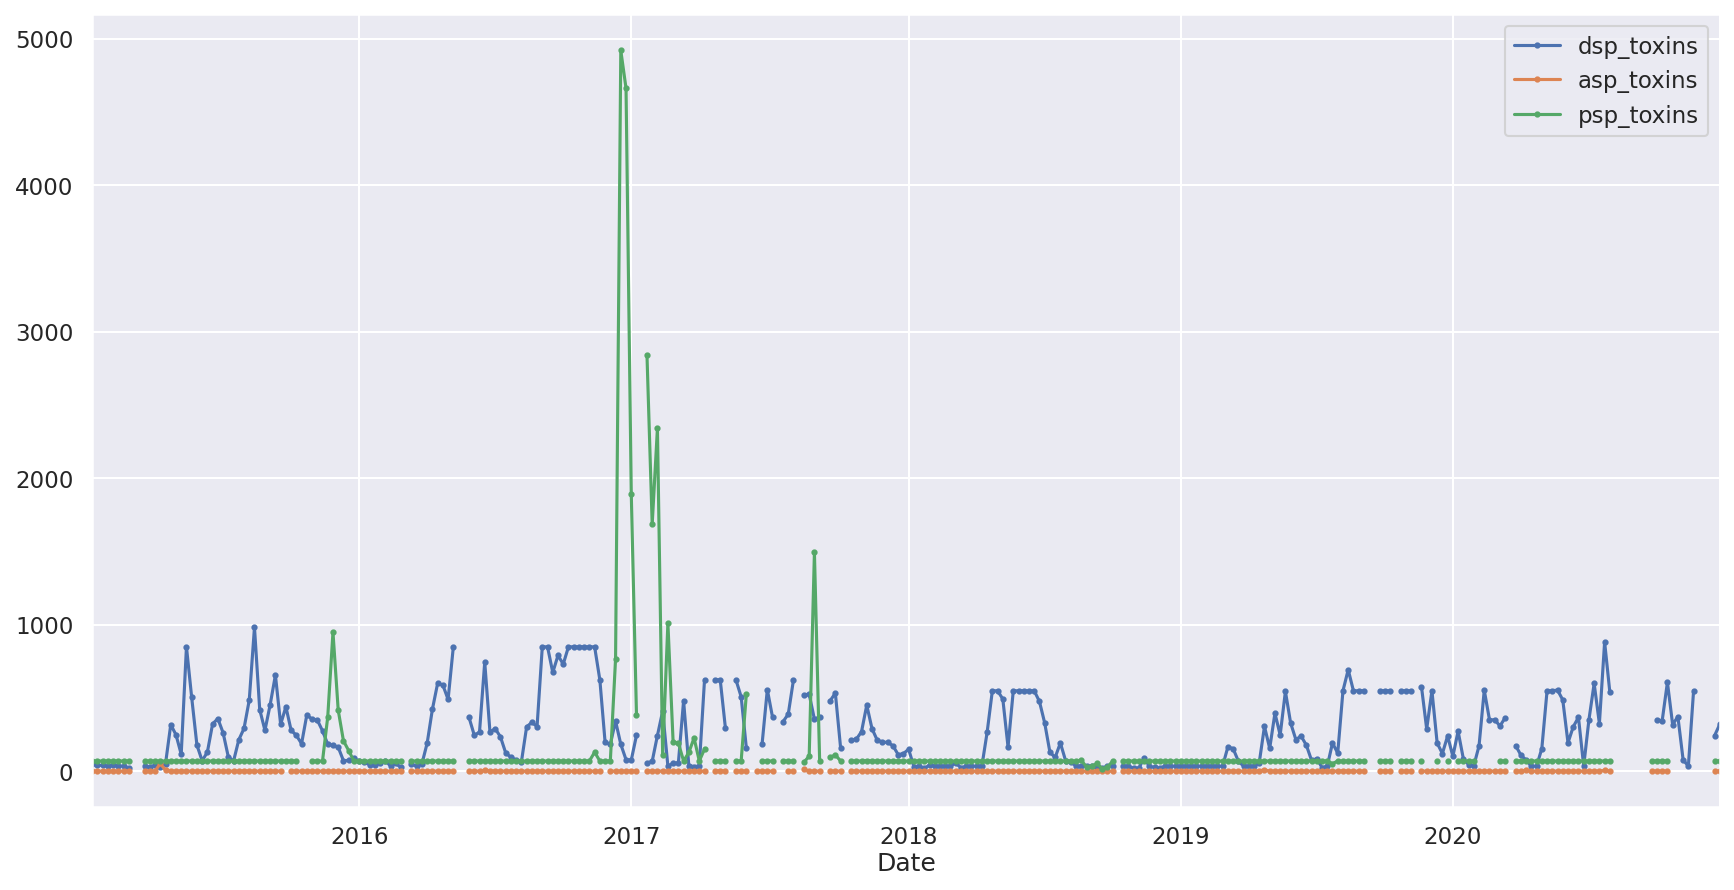

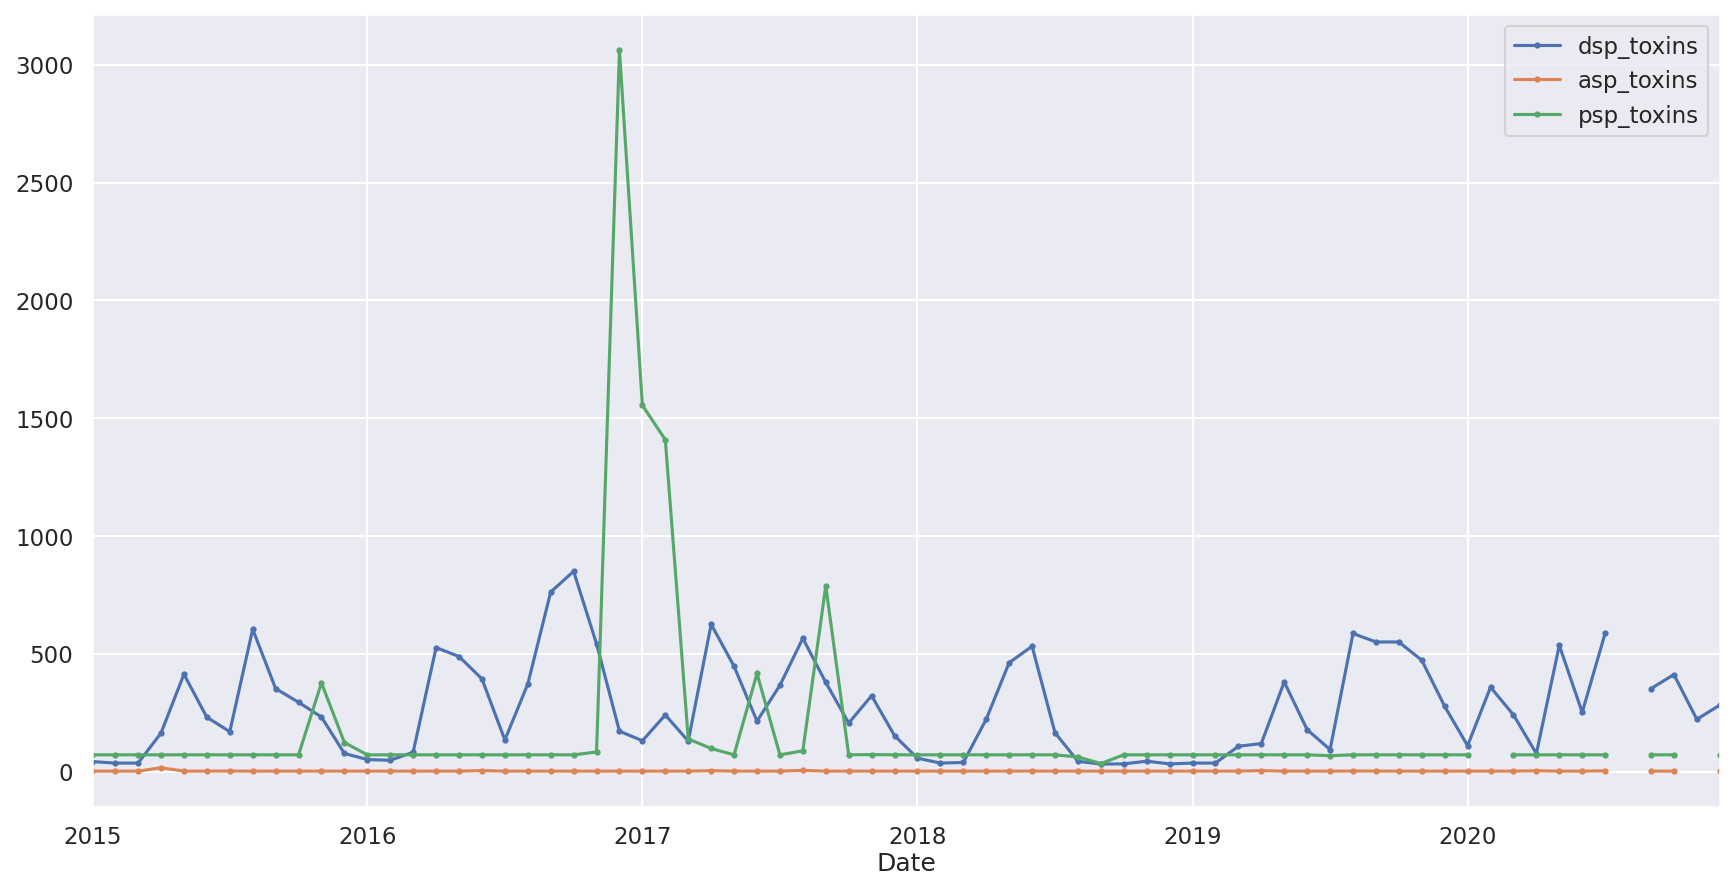

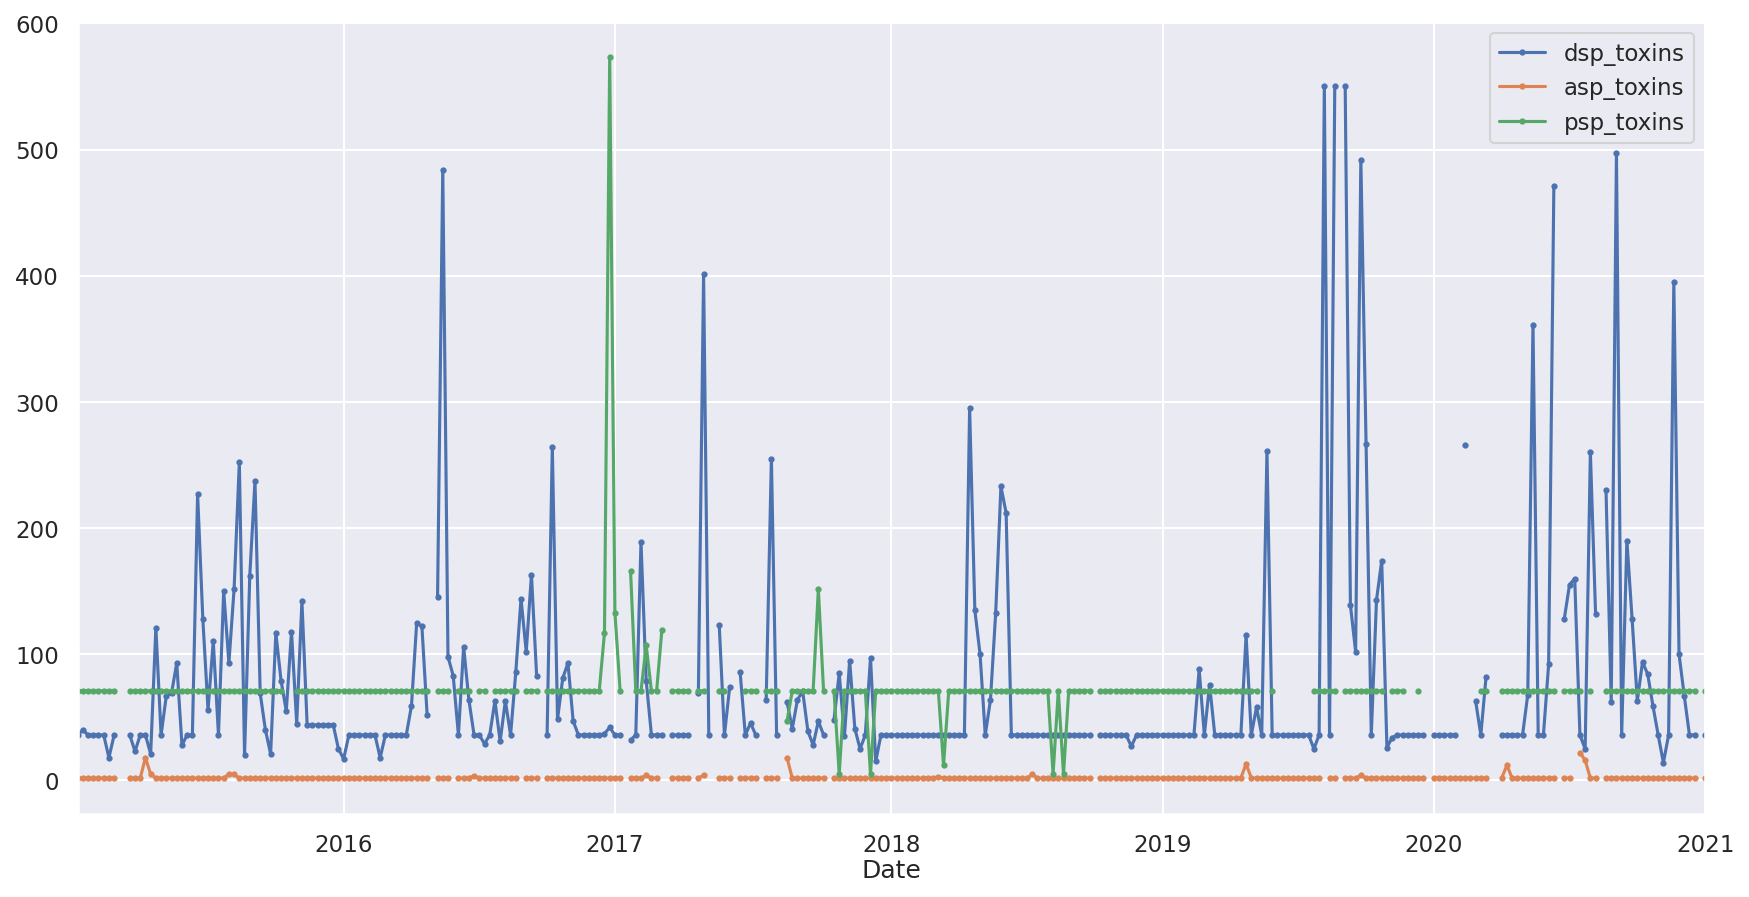

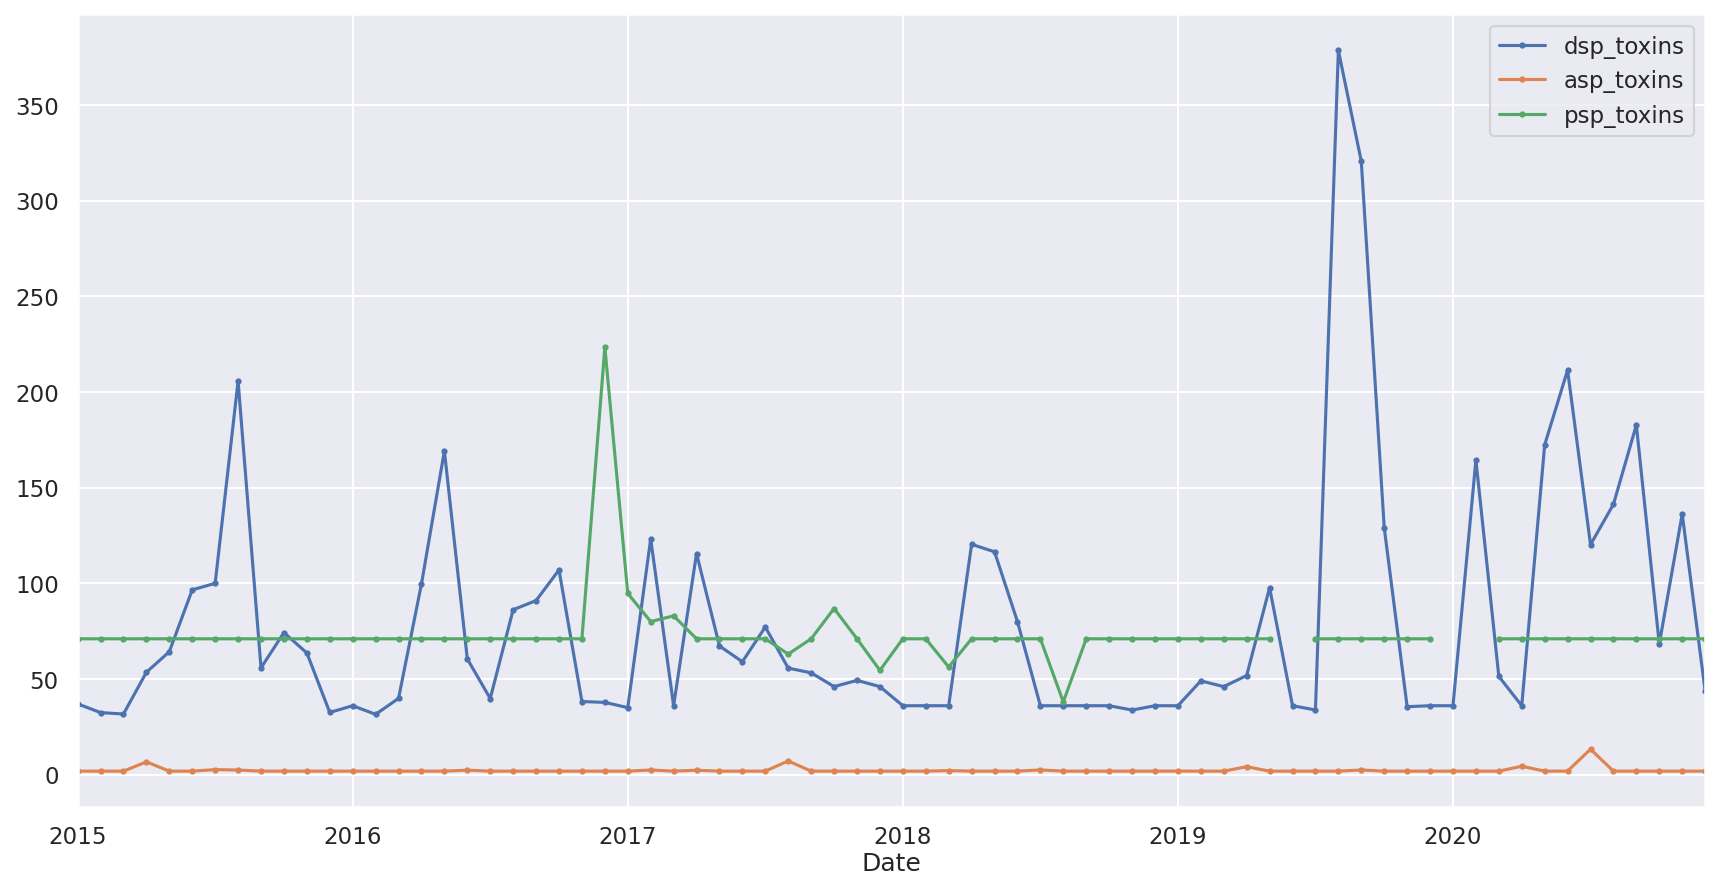

In [9]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "M")

## Compare species

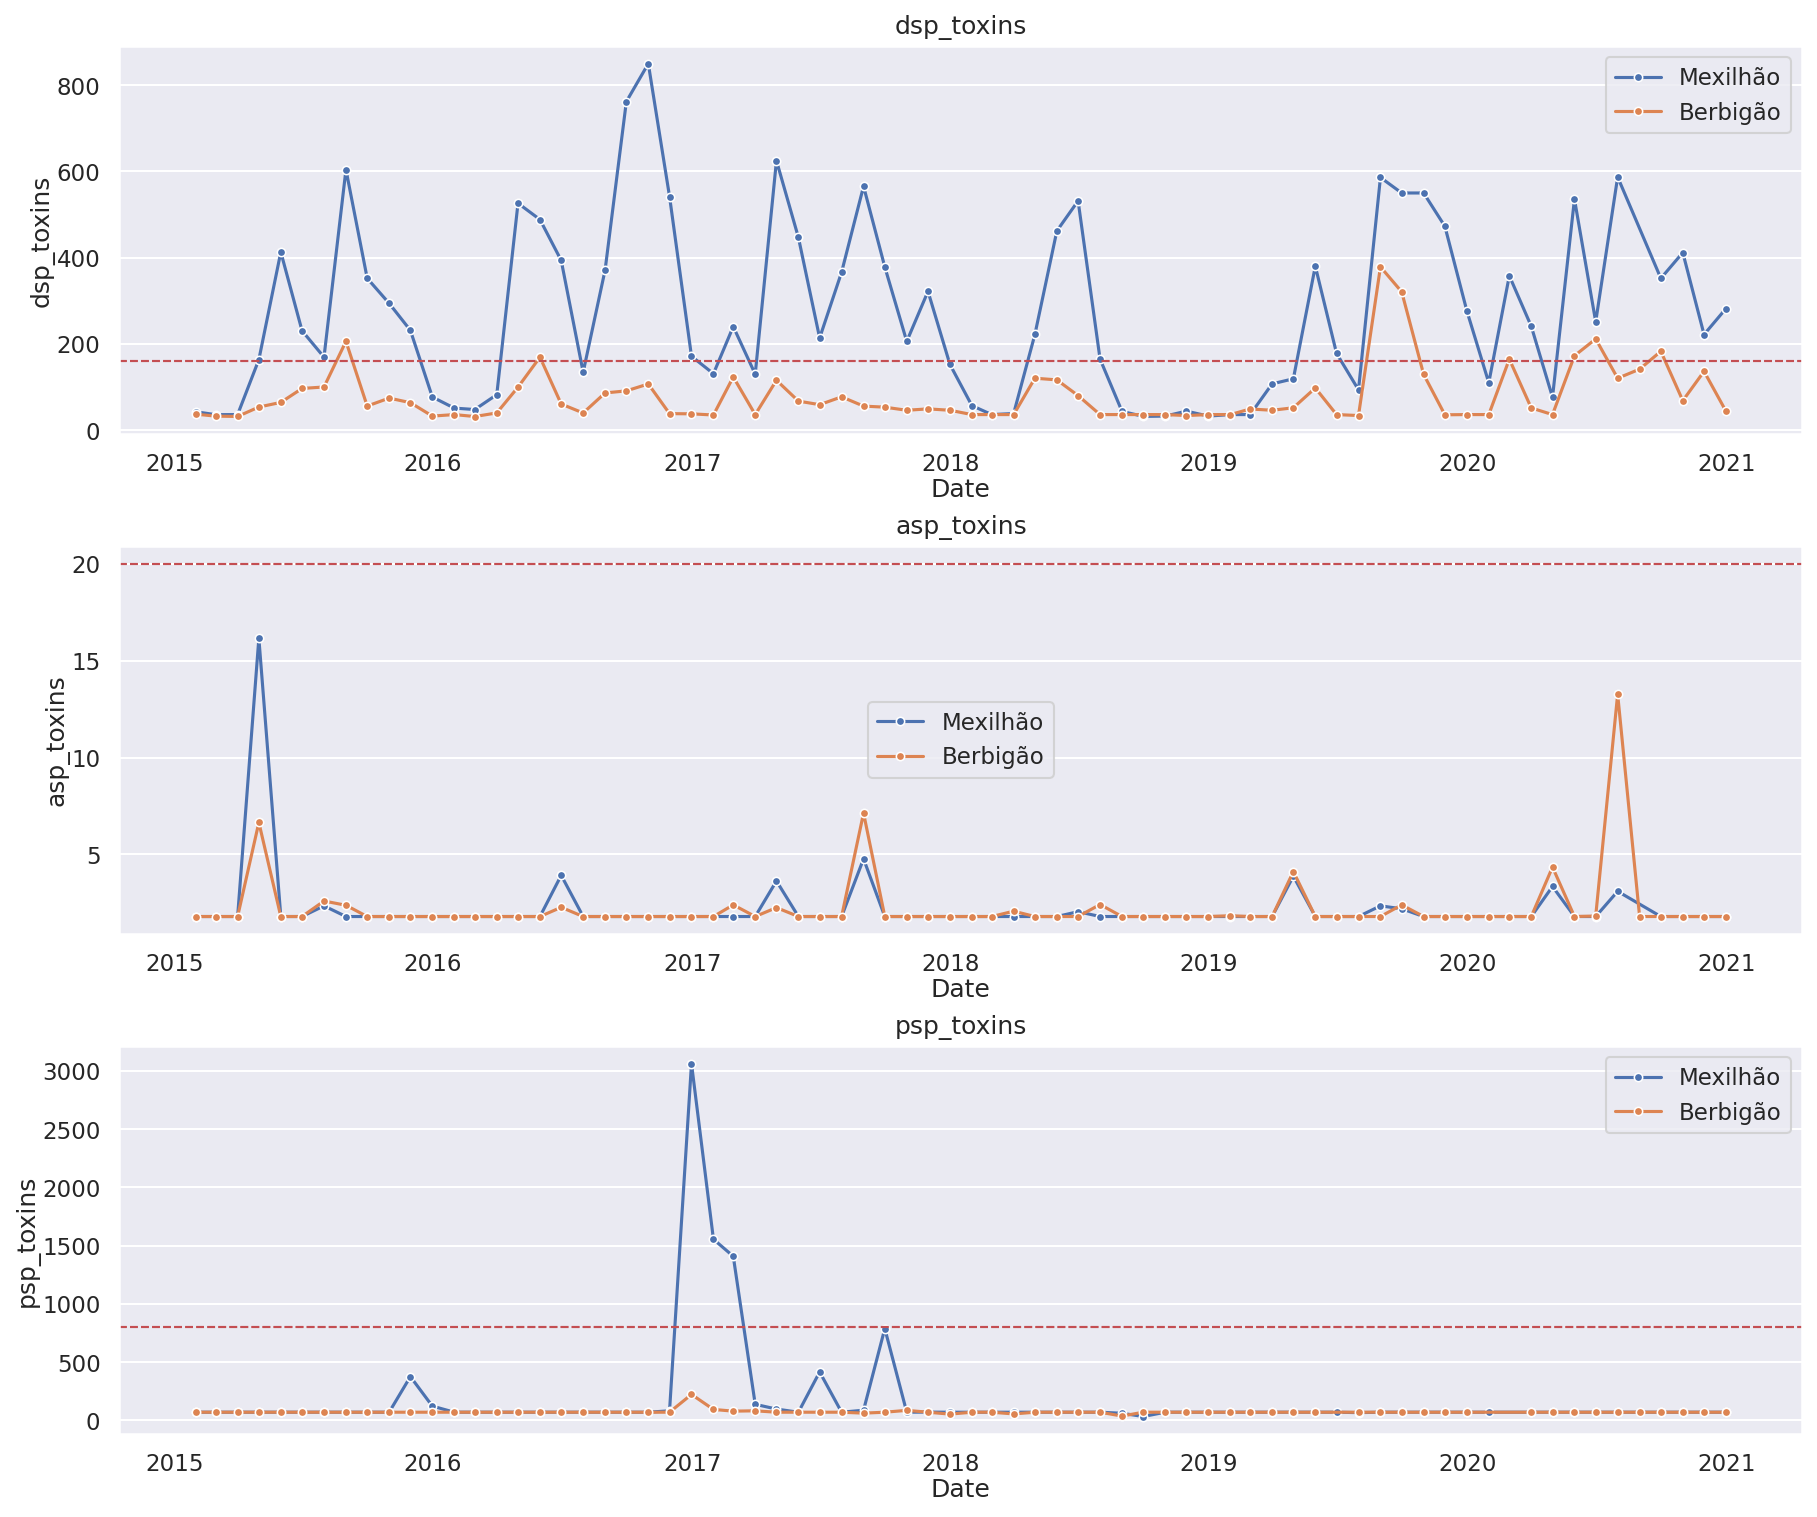

In [9]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

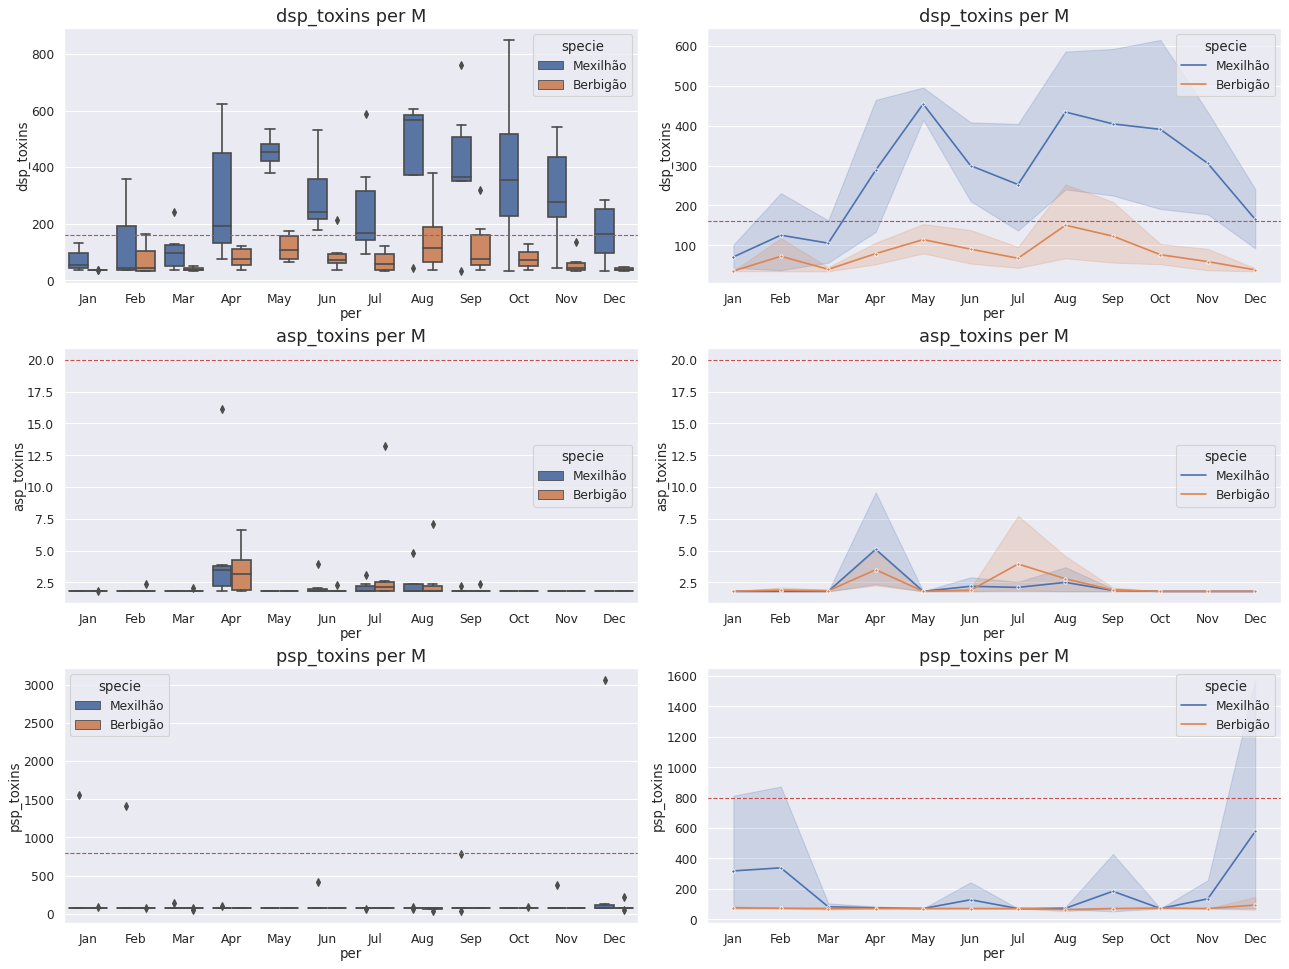

In [10]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

### DISPLAY

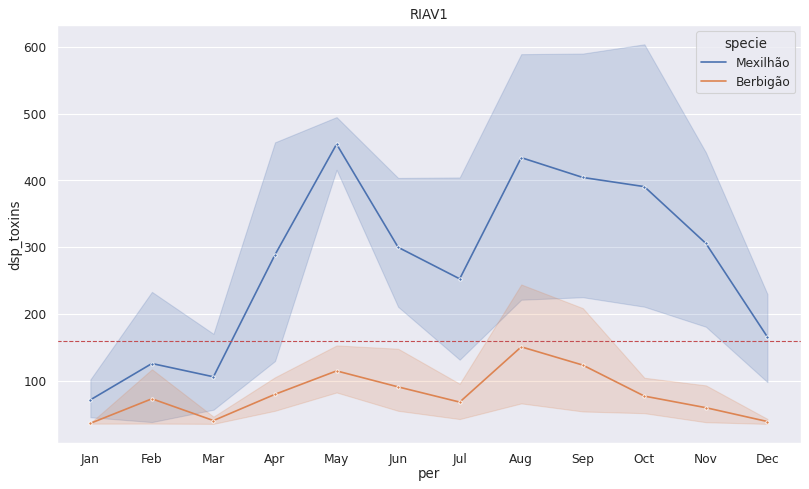

In [14]:
by="M"
#fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True, dpi=80)
fig, ax = plt.subplots(1,1, figsize=(10,6), constrained_layout=True, dpi=80)

#ax[0] = compare_species_seasonality(biotoxins_ts, "RIAV1", species, "dsp_toxins", by, ax[0], 160,"lineplot")
#ax[1] = compare_species_seasonality(biotoxins_ts, "RIAV2", species, "dsp_toxins", by, ax[1], 160,"lineplot")
#ax[0].set_title("RIAV1")
#ax[1].set_title("RIAV2")

ax = compare_species_seasonality(biotoxins_ts, "RIAV1", species, "dsp_toxins", by, ax, 160,"lineplot")
ax.set_title("RIAV1")

plt.show()

## Trend

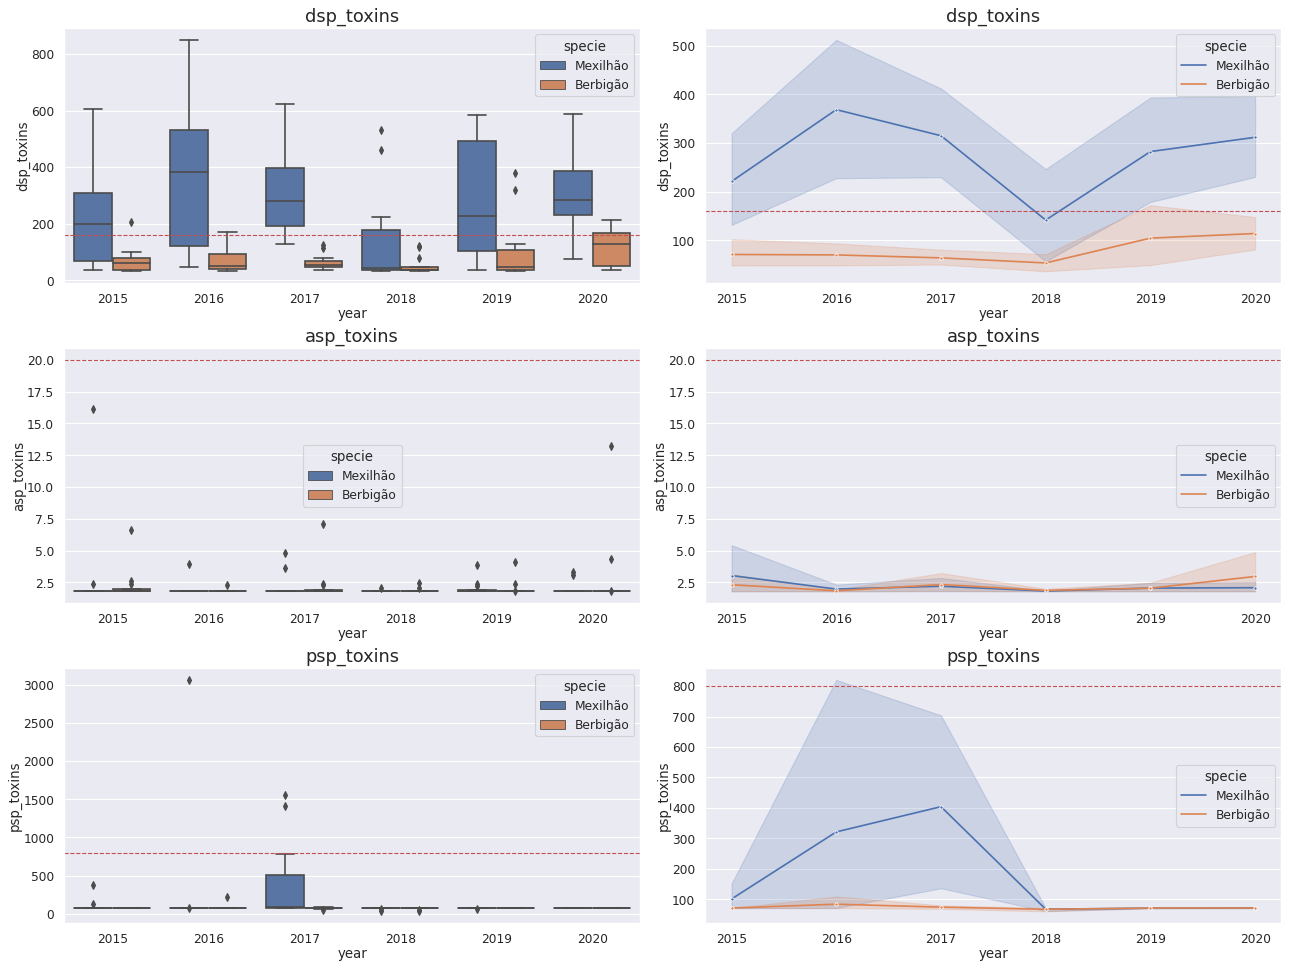

In [27]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

### DISPLAY

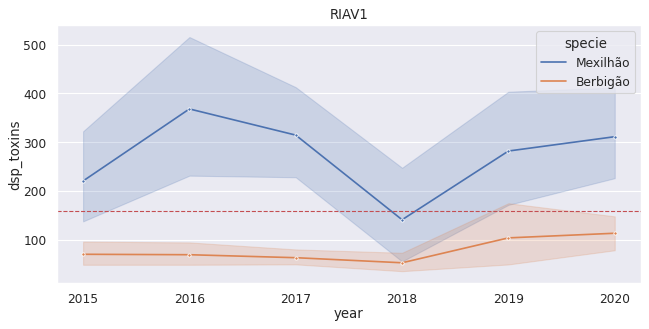

In [12]:
#fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True, dpi=80)
fig, ax = plt.subplots(1,1, figsize=(8,4), constrained_layout=True, dpi=80)

#ax[0] = compare_species_trend(biotoxins_ts, "RIAV1", species, "dsp_toxins", ax[0], 160,"lineplot")
#ax[1] = compare_species_trend(biotoxins_ts, "RIAV2", species, "dsp_toxins", ax[1], 160,"lineplot")

#ax[0].set_title("RIAV1")
#ax[1].set_title("RIAV2")

ax = compare_species_trend(biotoxins_ts, "RIAV1", species, "dsp_toxins", ax, 160,"lineplot")
ax.set_title("RIAV1")


plt.show()

# RIAV2

In [8]:
area = "RIAV2"
species = ["Mexilhão", "Berbigão"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão                  302
Mexilhão                  288
Longueirão                100
Amêijoa-macha              98
Amêijoa-boa                54
Amêijoa-japonesa           44
Ostra-japonesa/gigante     35
Ostra                      11
Amêijoa                     1
Name: Species, dtype: int64

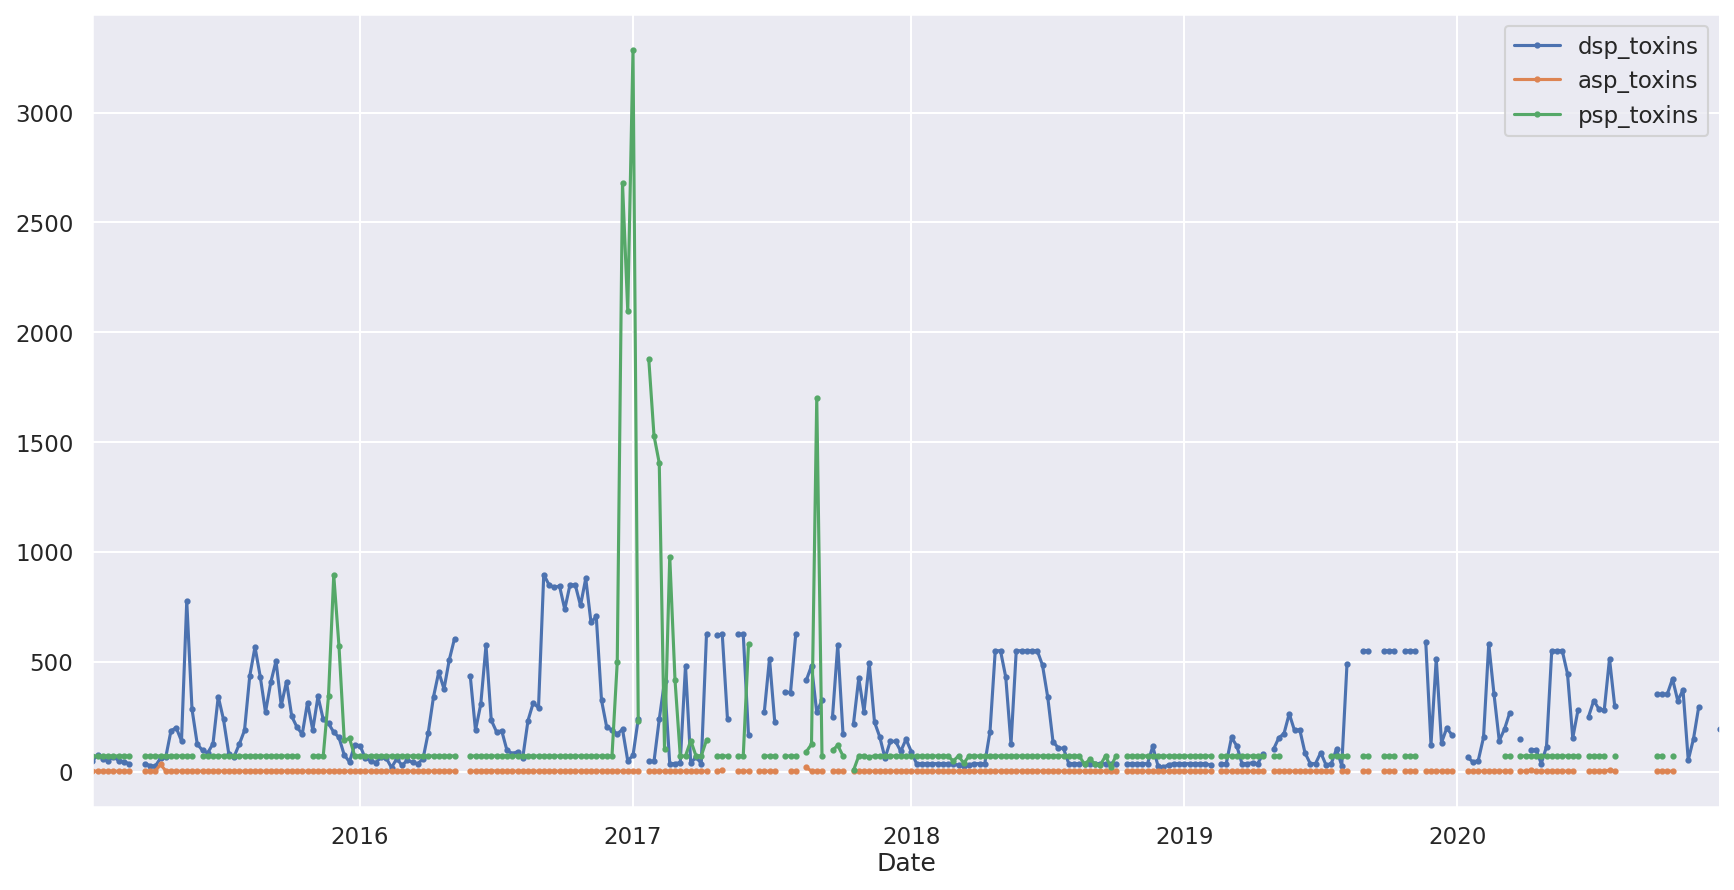

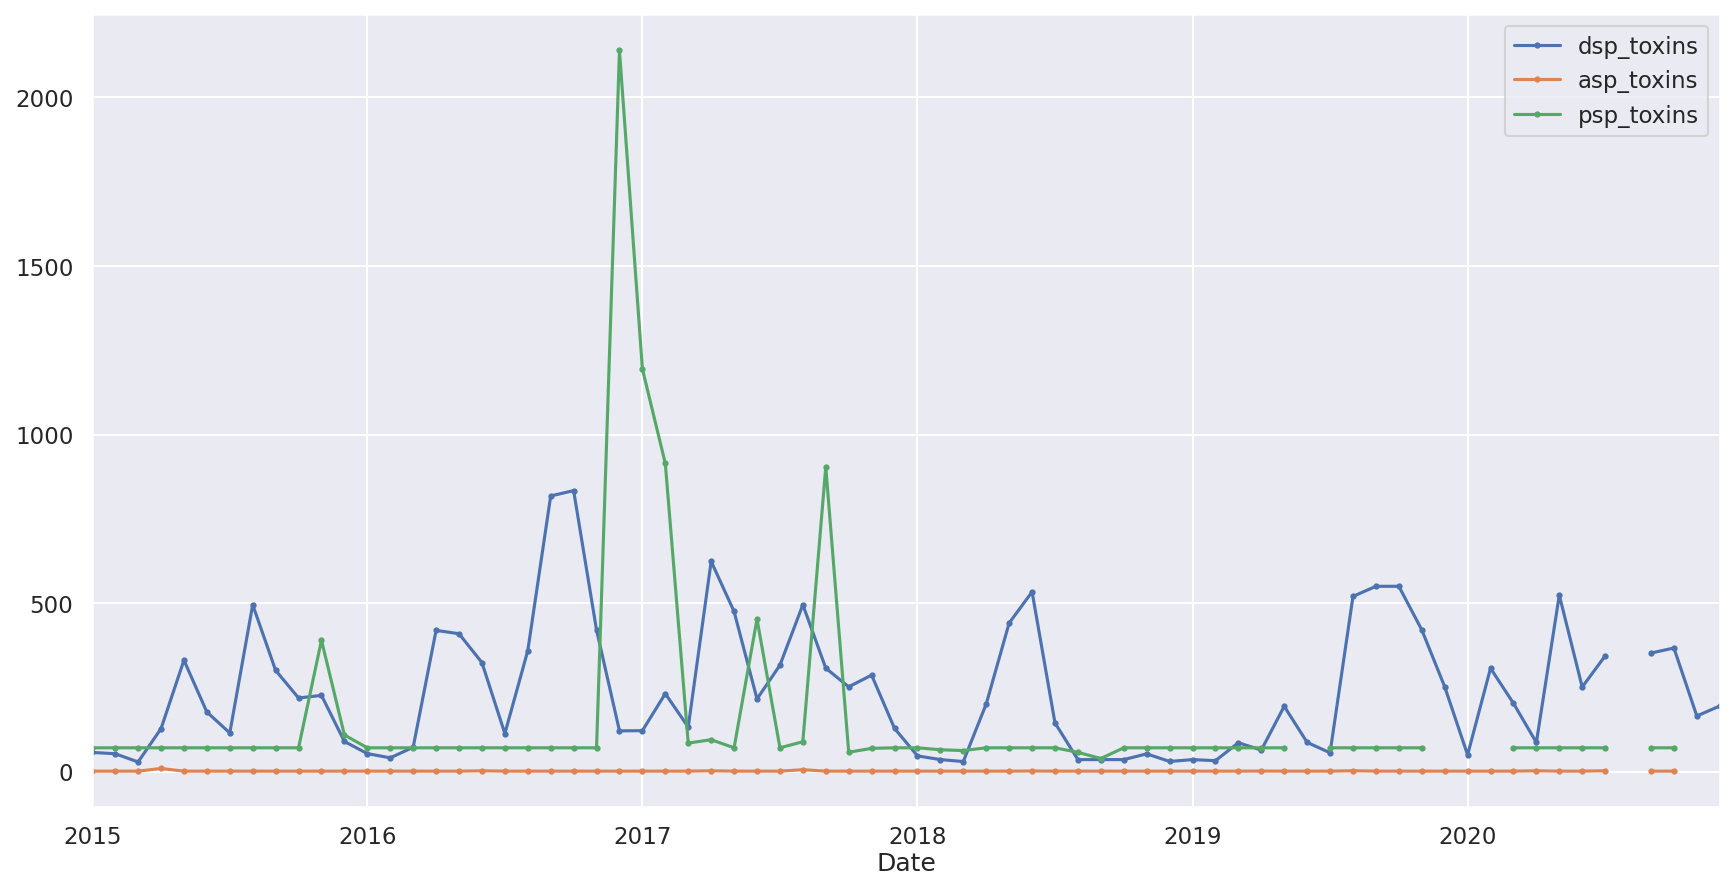

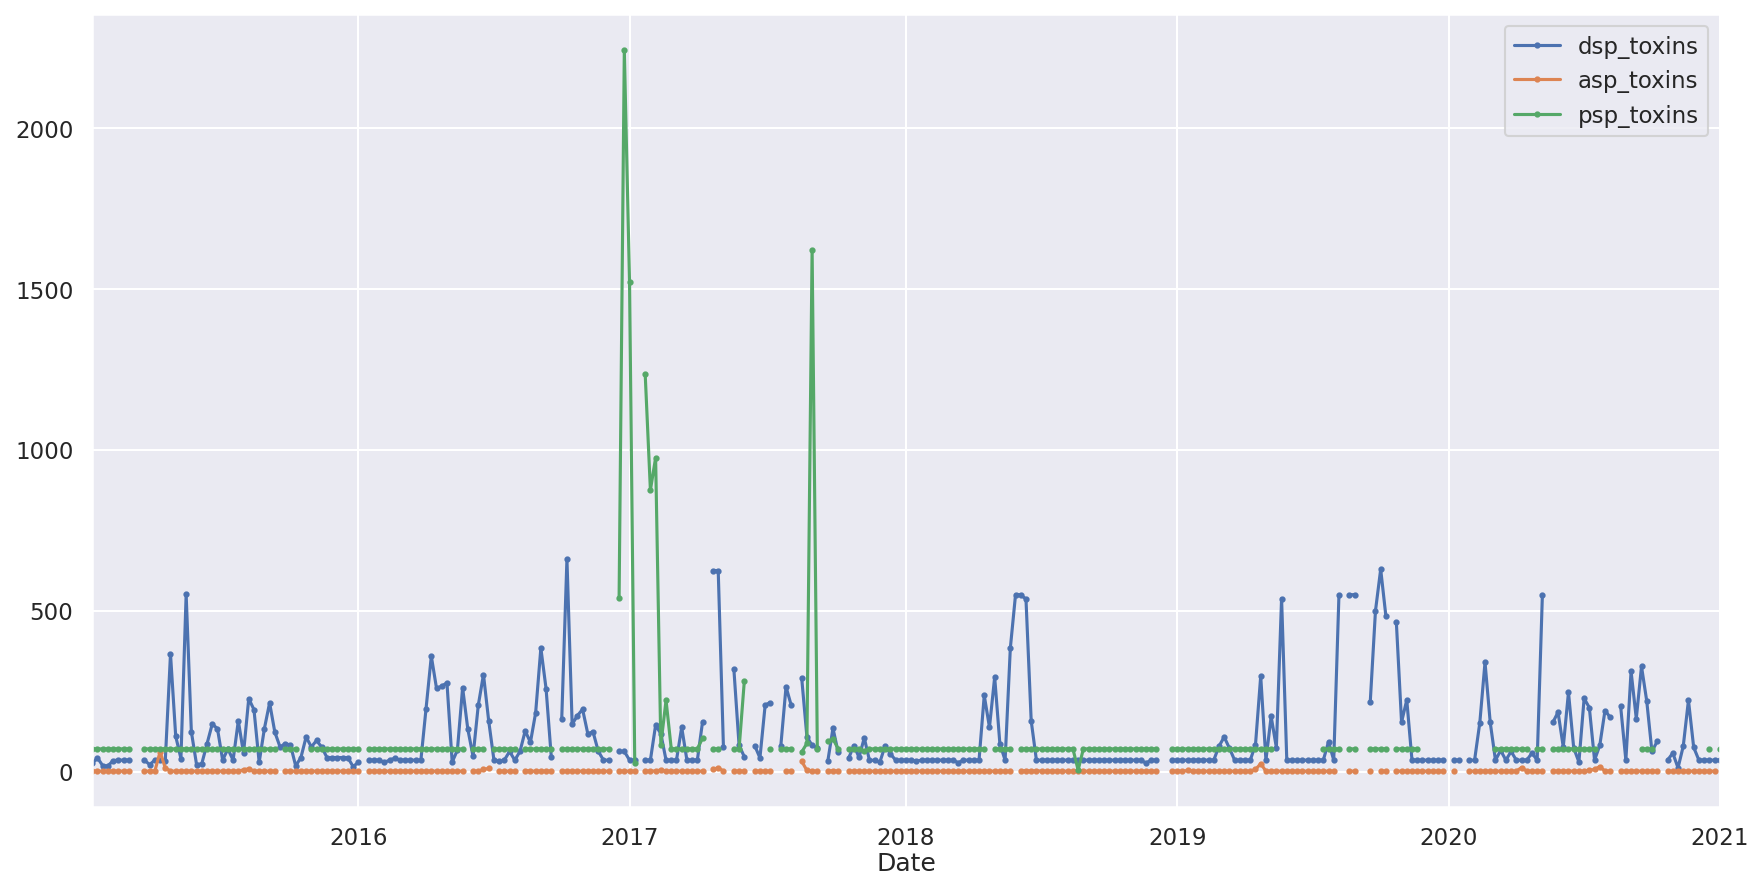

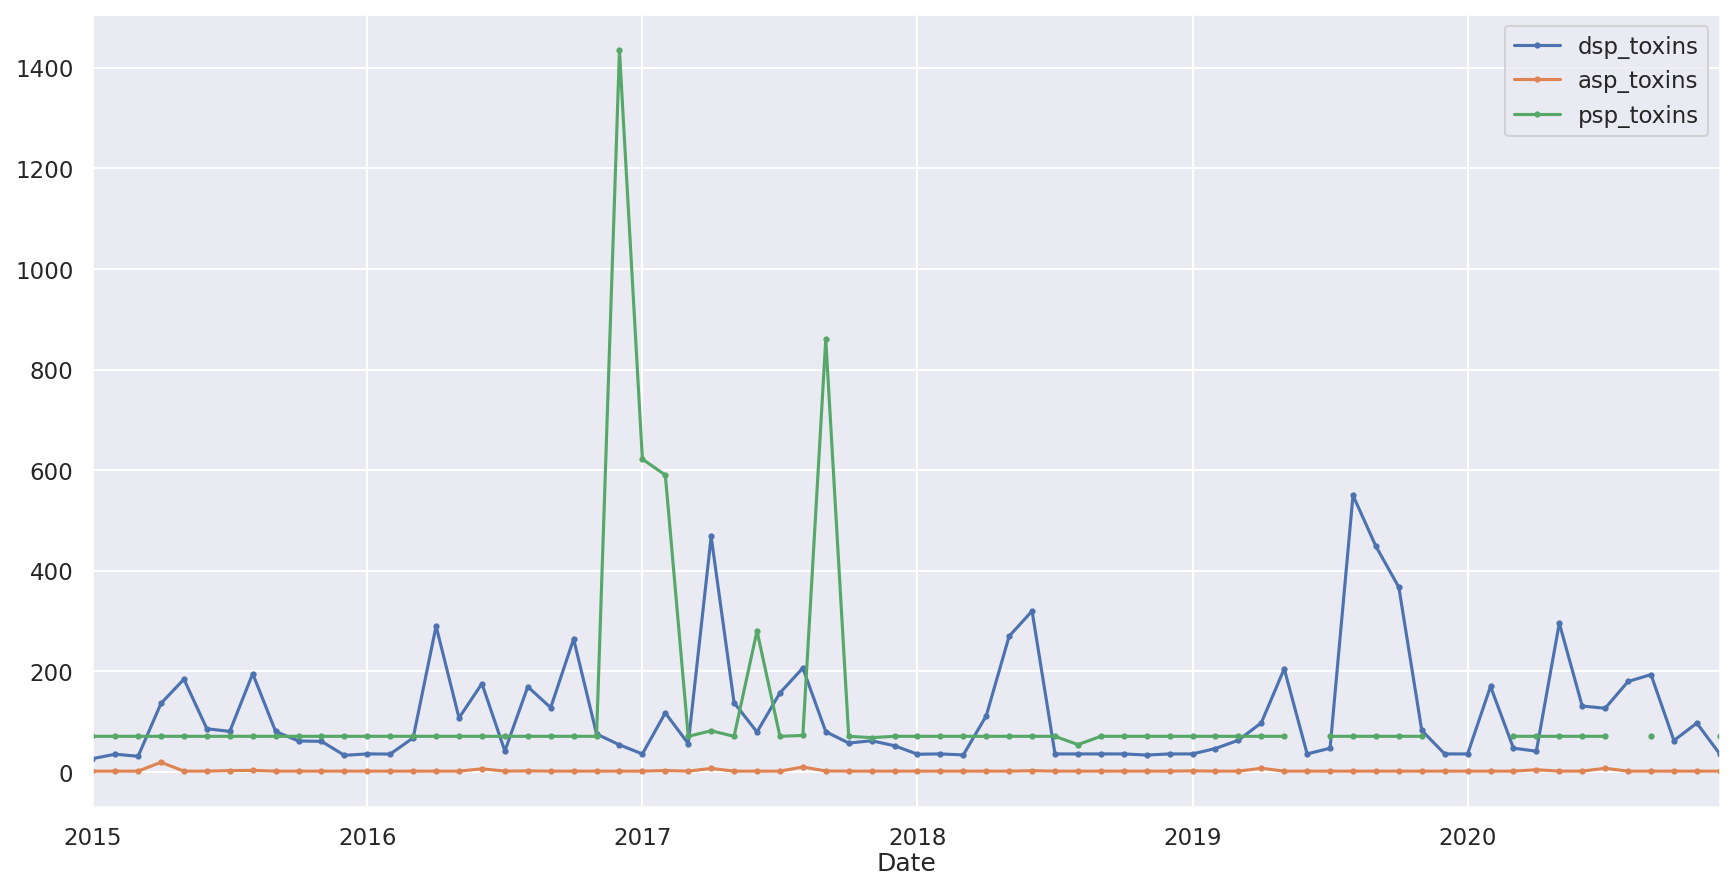

In [9]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "M")

## Compare species

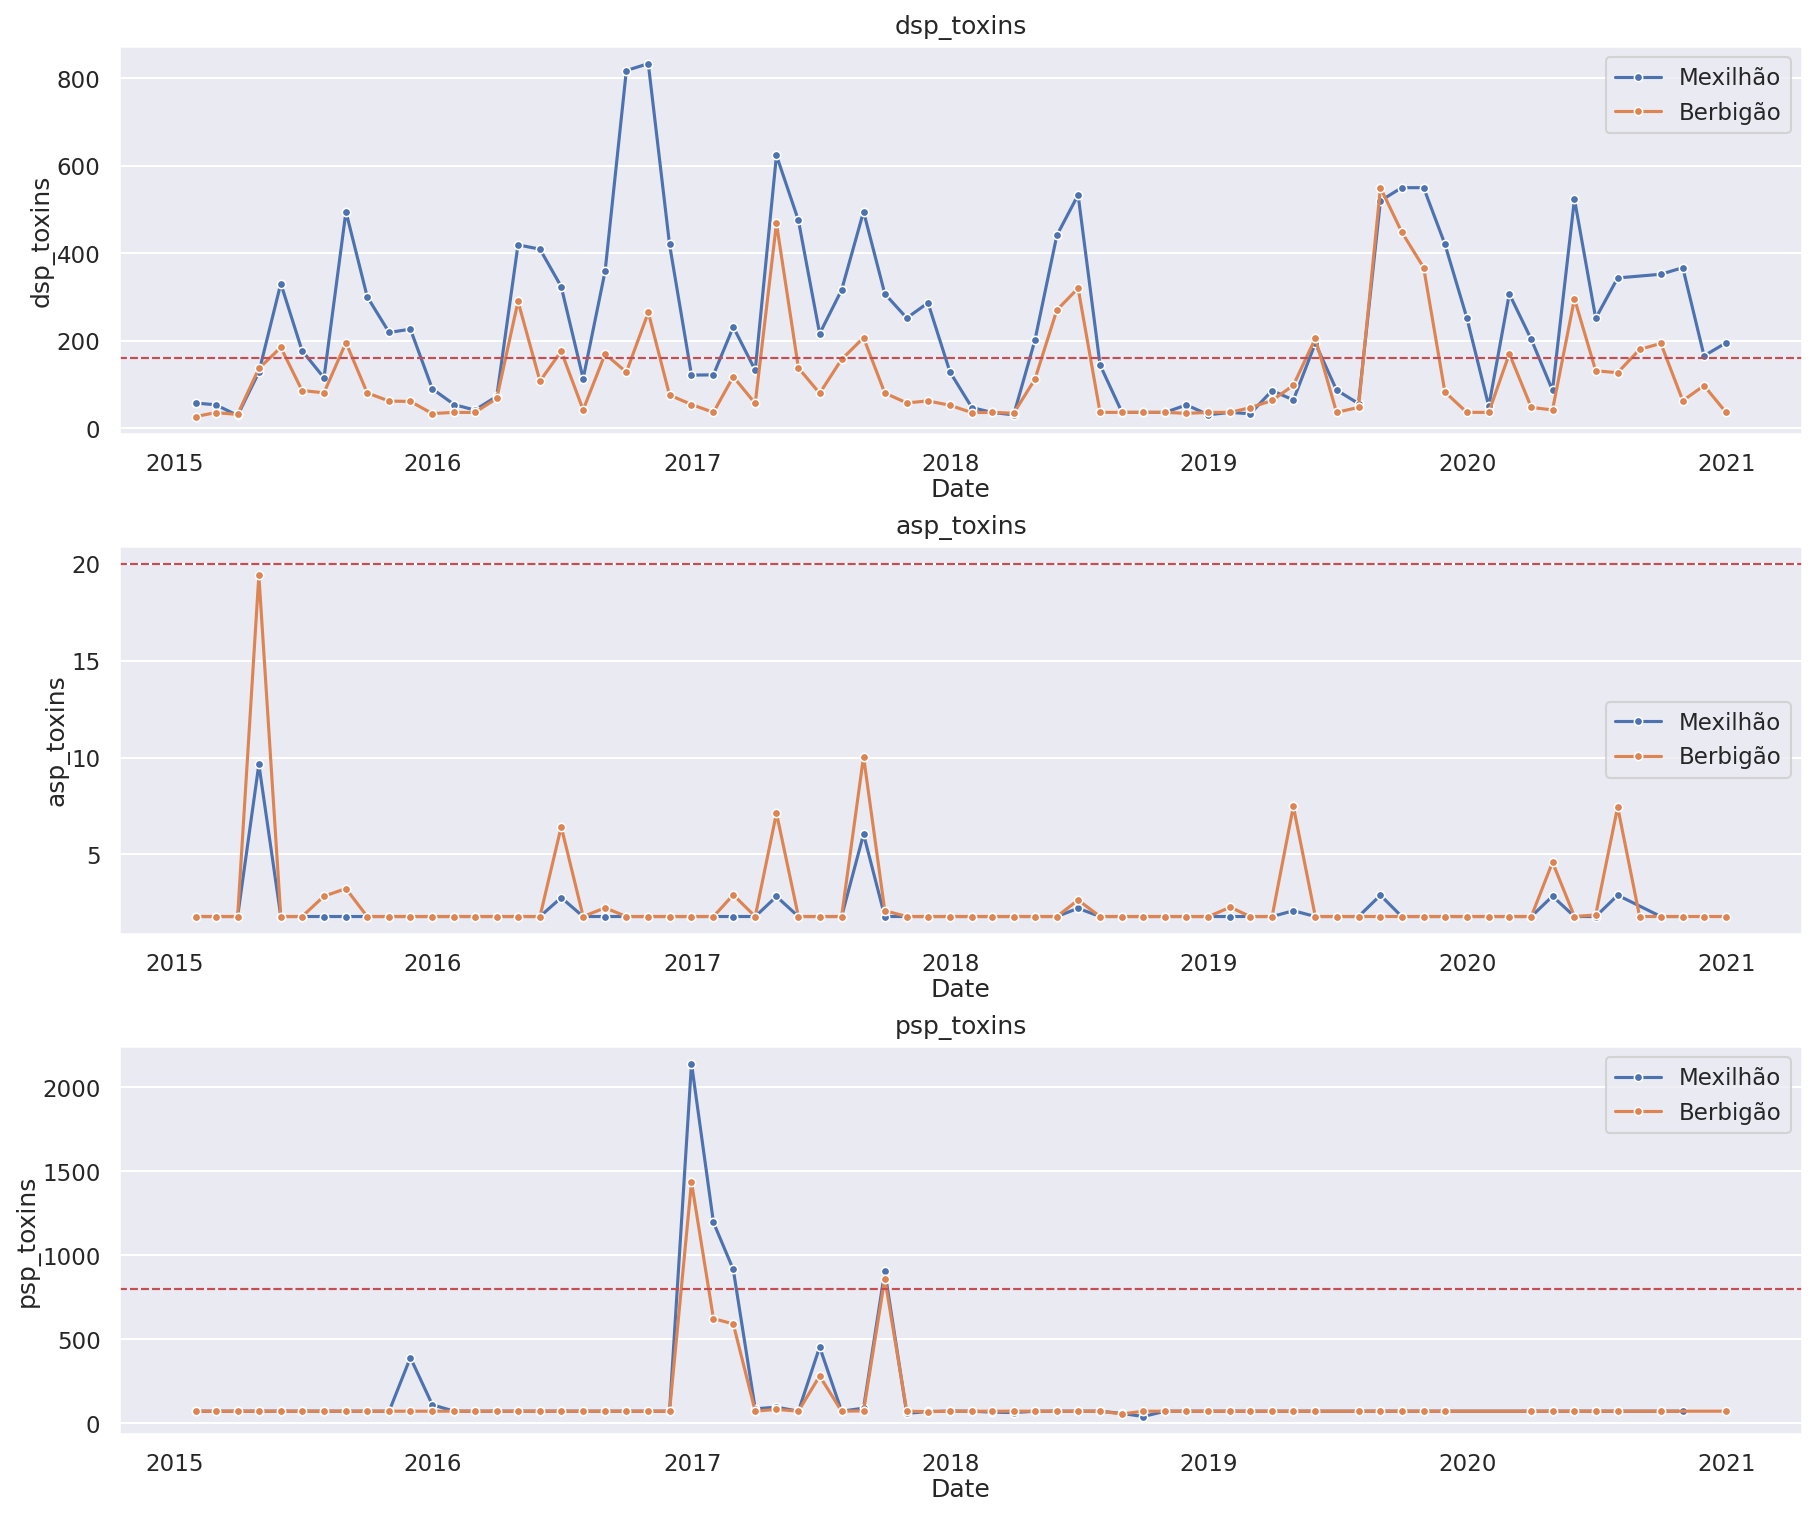

In [10]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

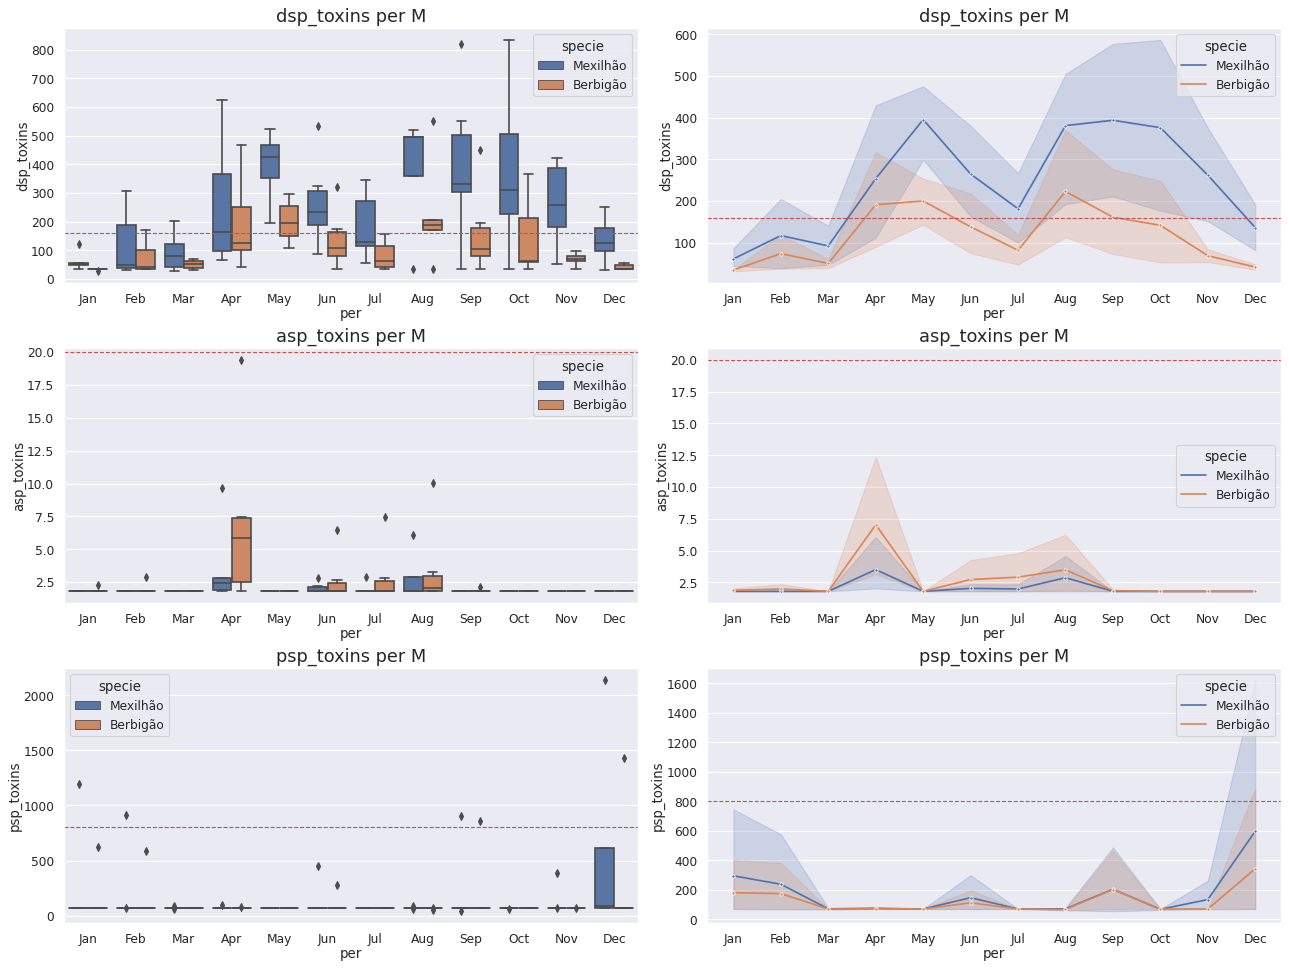

In [11]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

## Trend

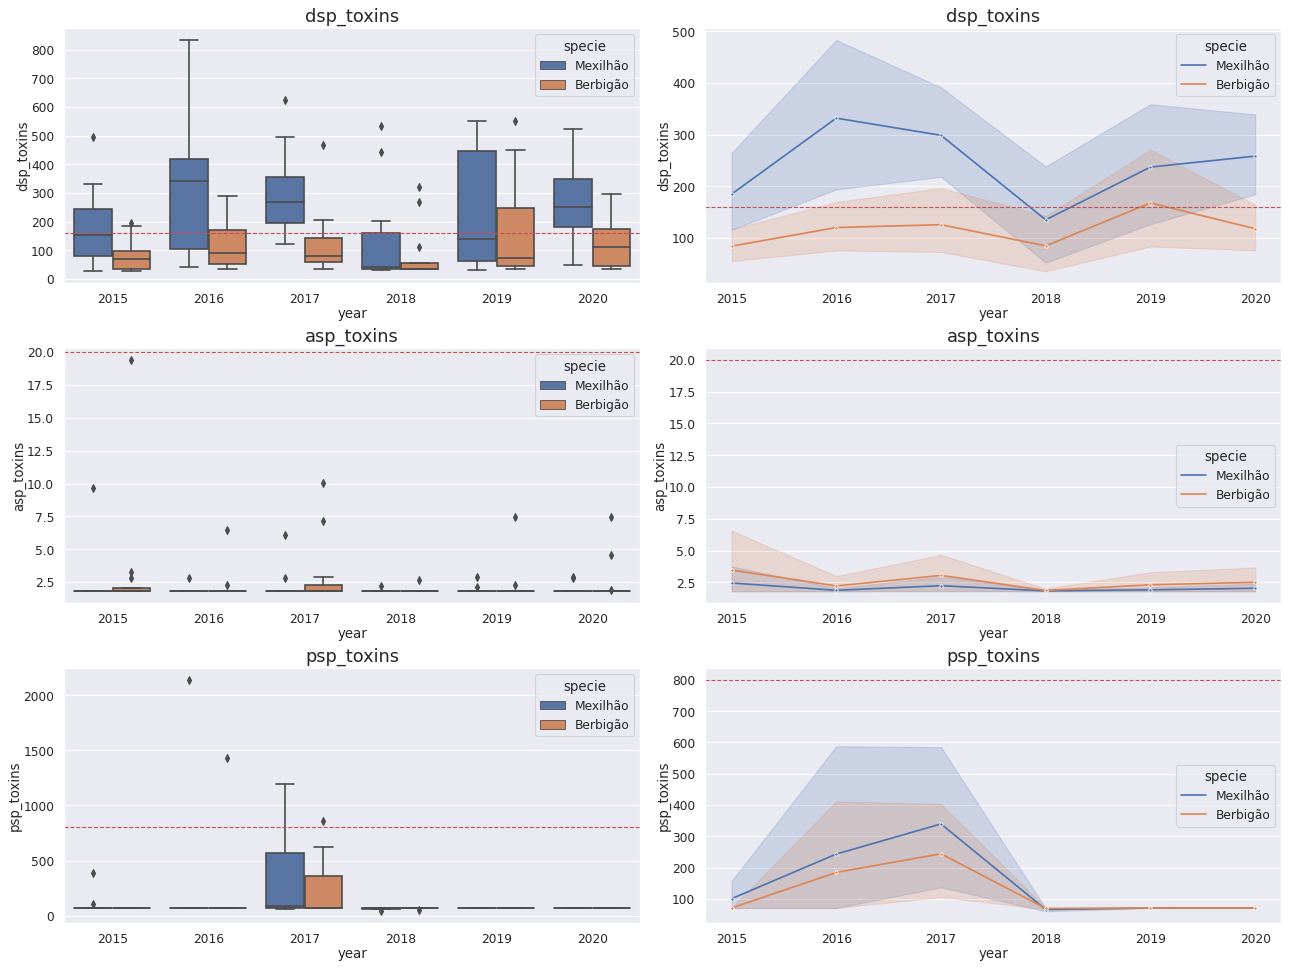

In [12]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

# L2

In [85]:
area = "L2"
species = ["Mexilhão", "Amêijoa-branca"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Mexilhão           251
Amêijoa-branca     240
Castanhola          42
Amêijoa-relógio     12
Telina               5
Pé-de-burrinho       1
Lapa                 1
Name: Species, dtype: int64

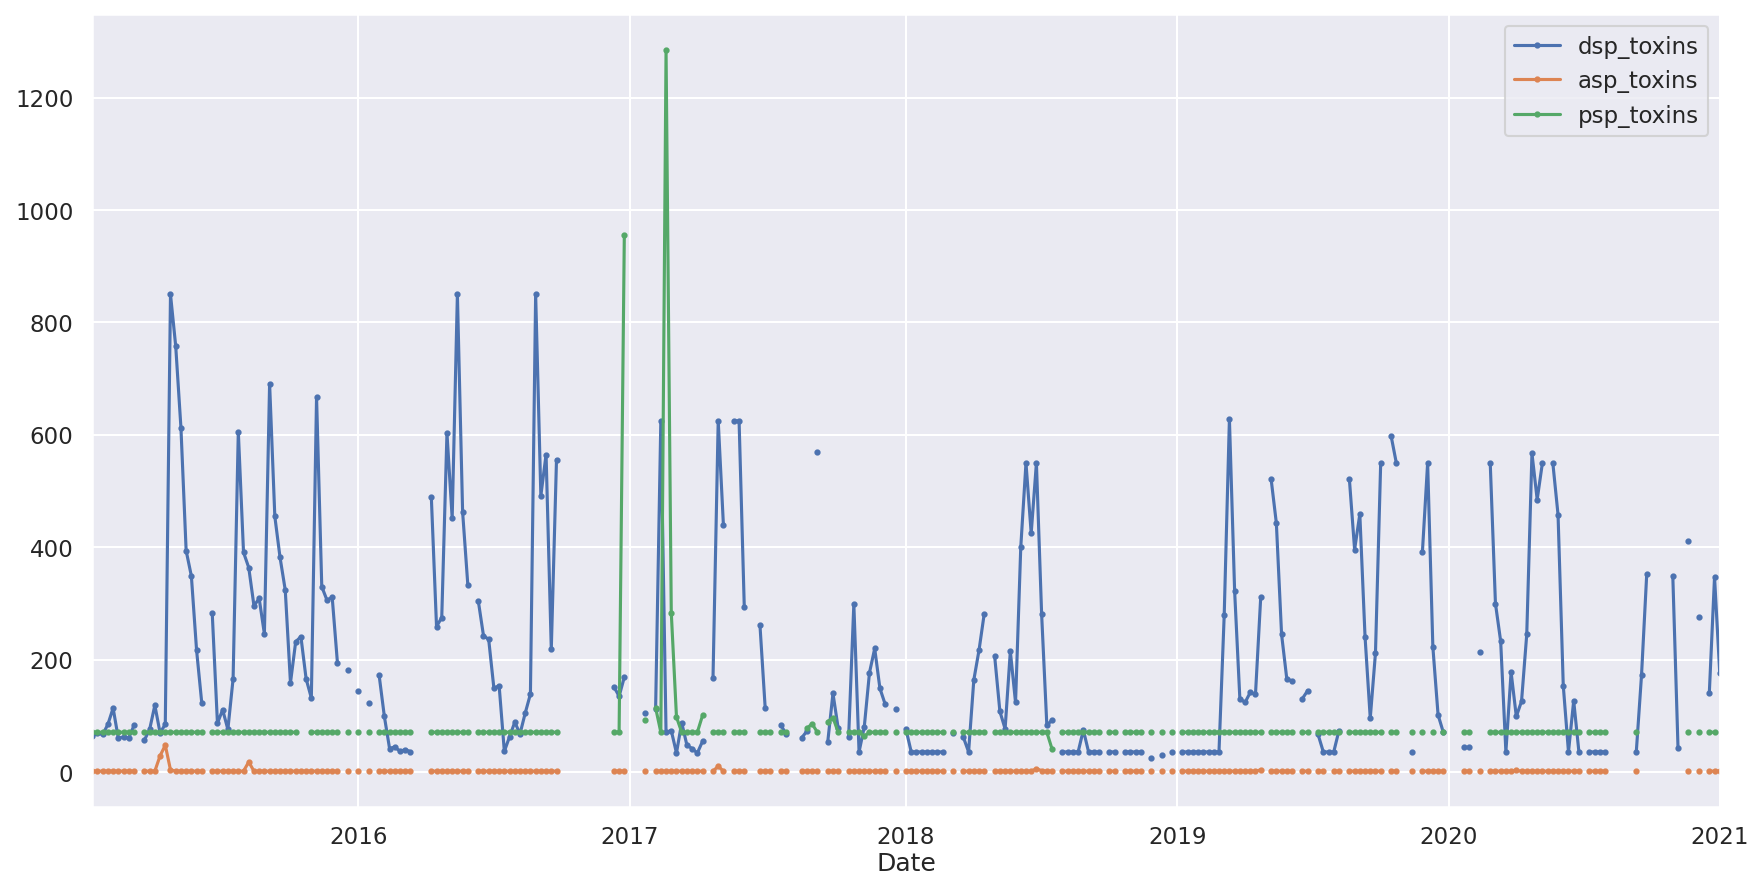

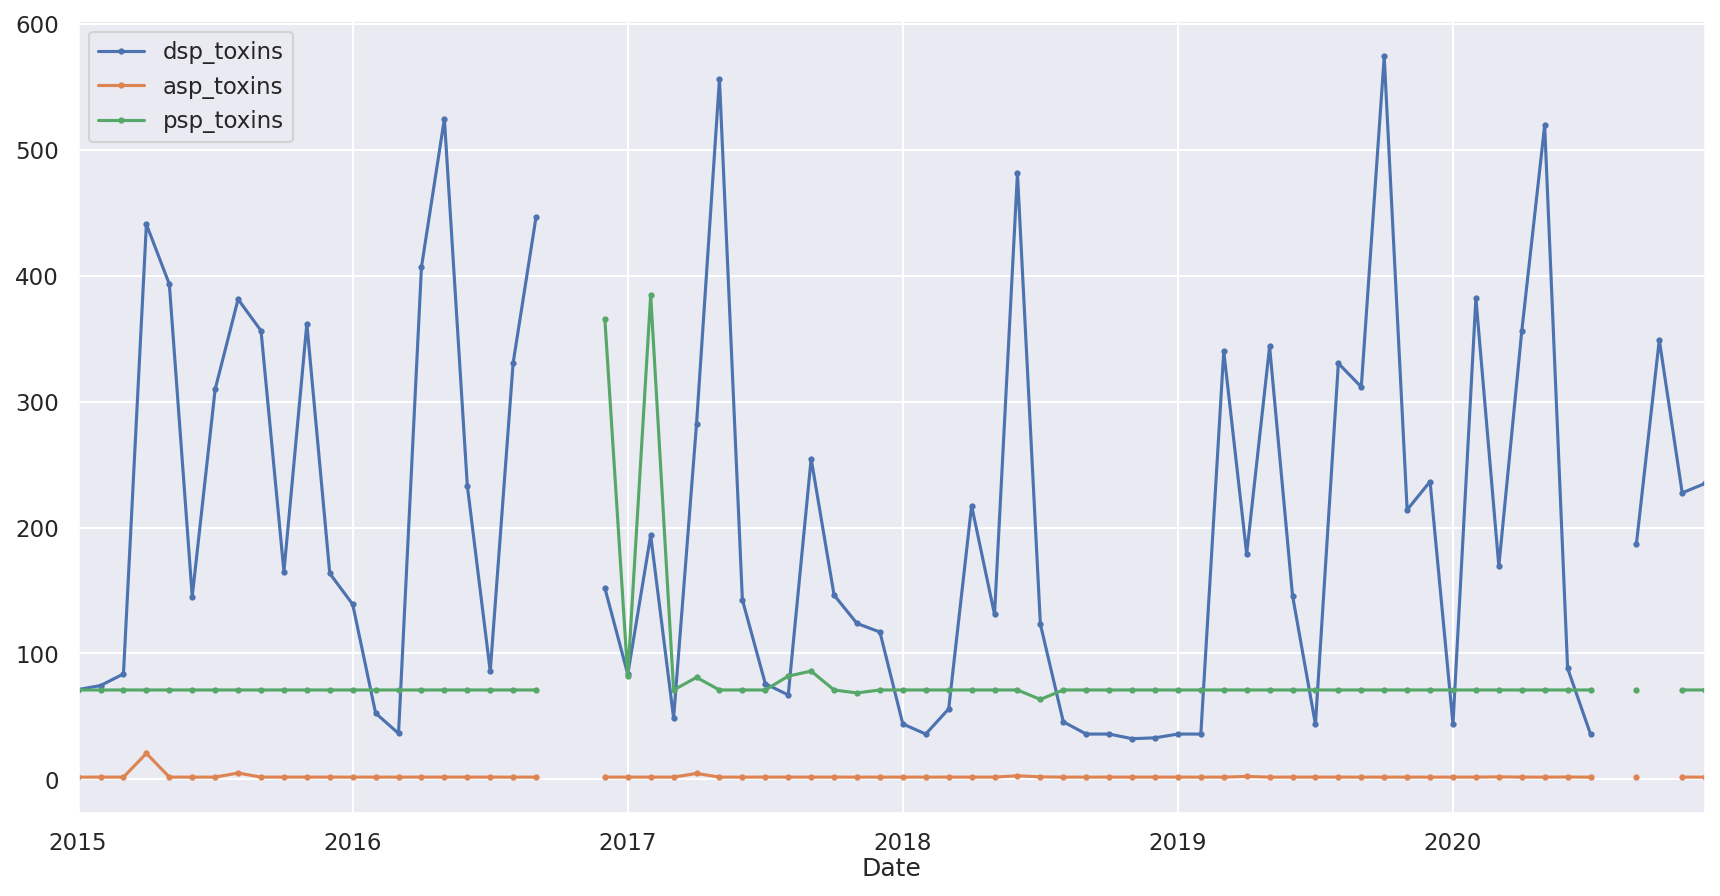

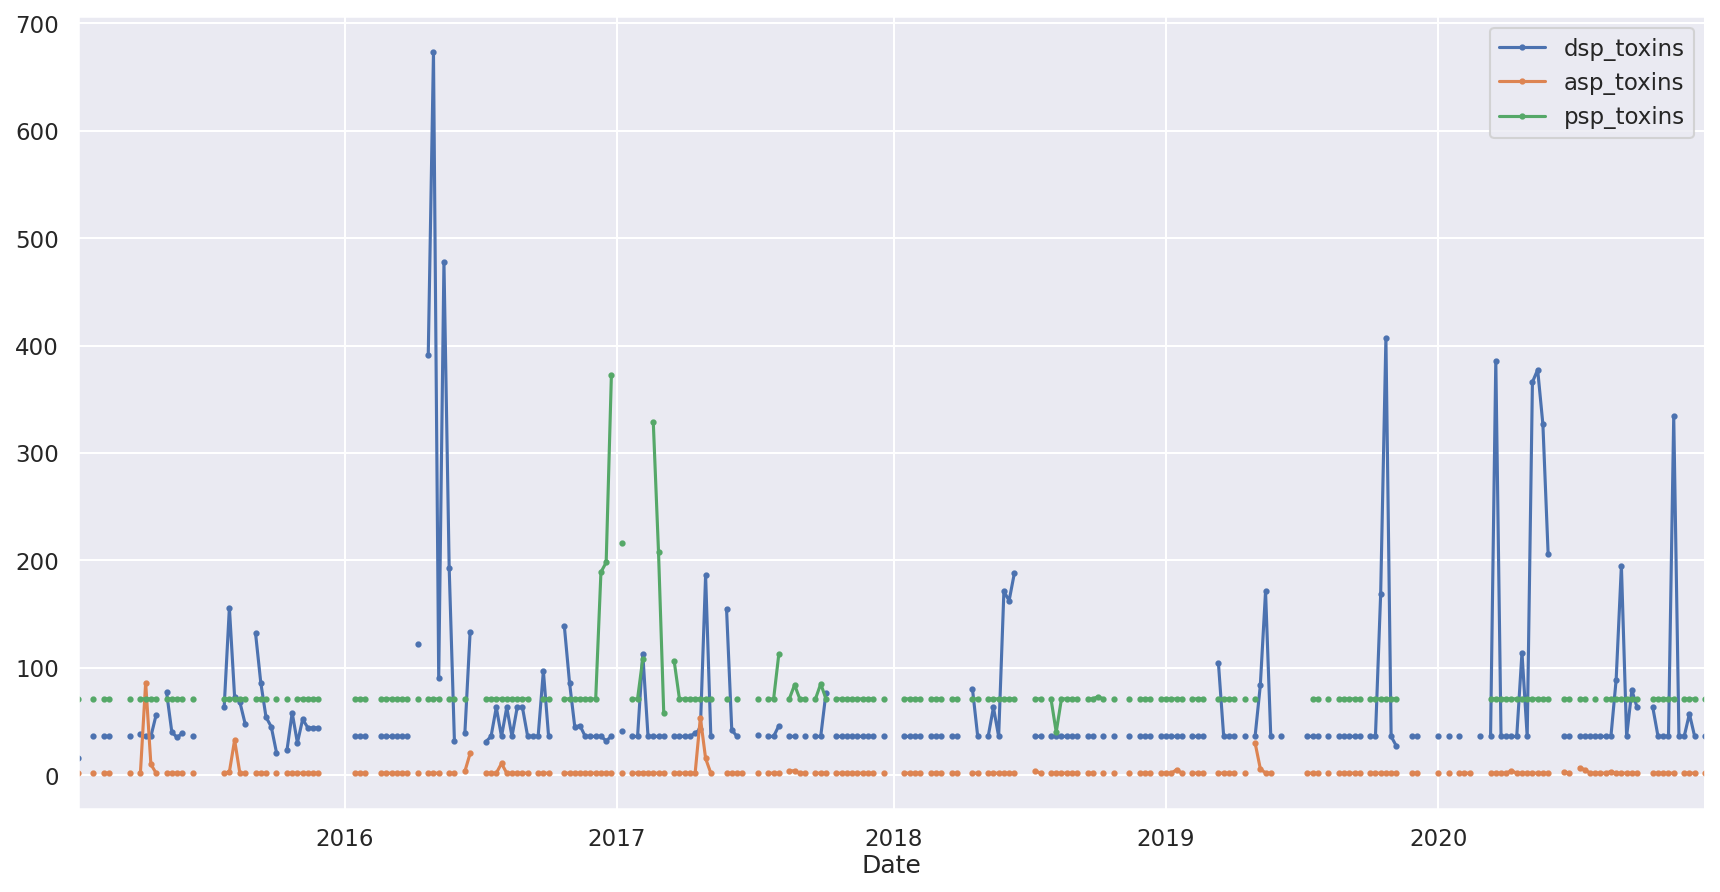

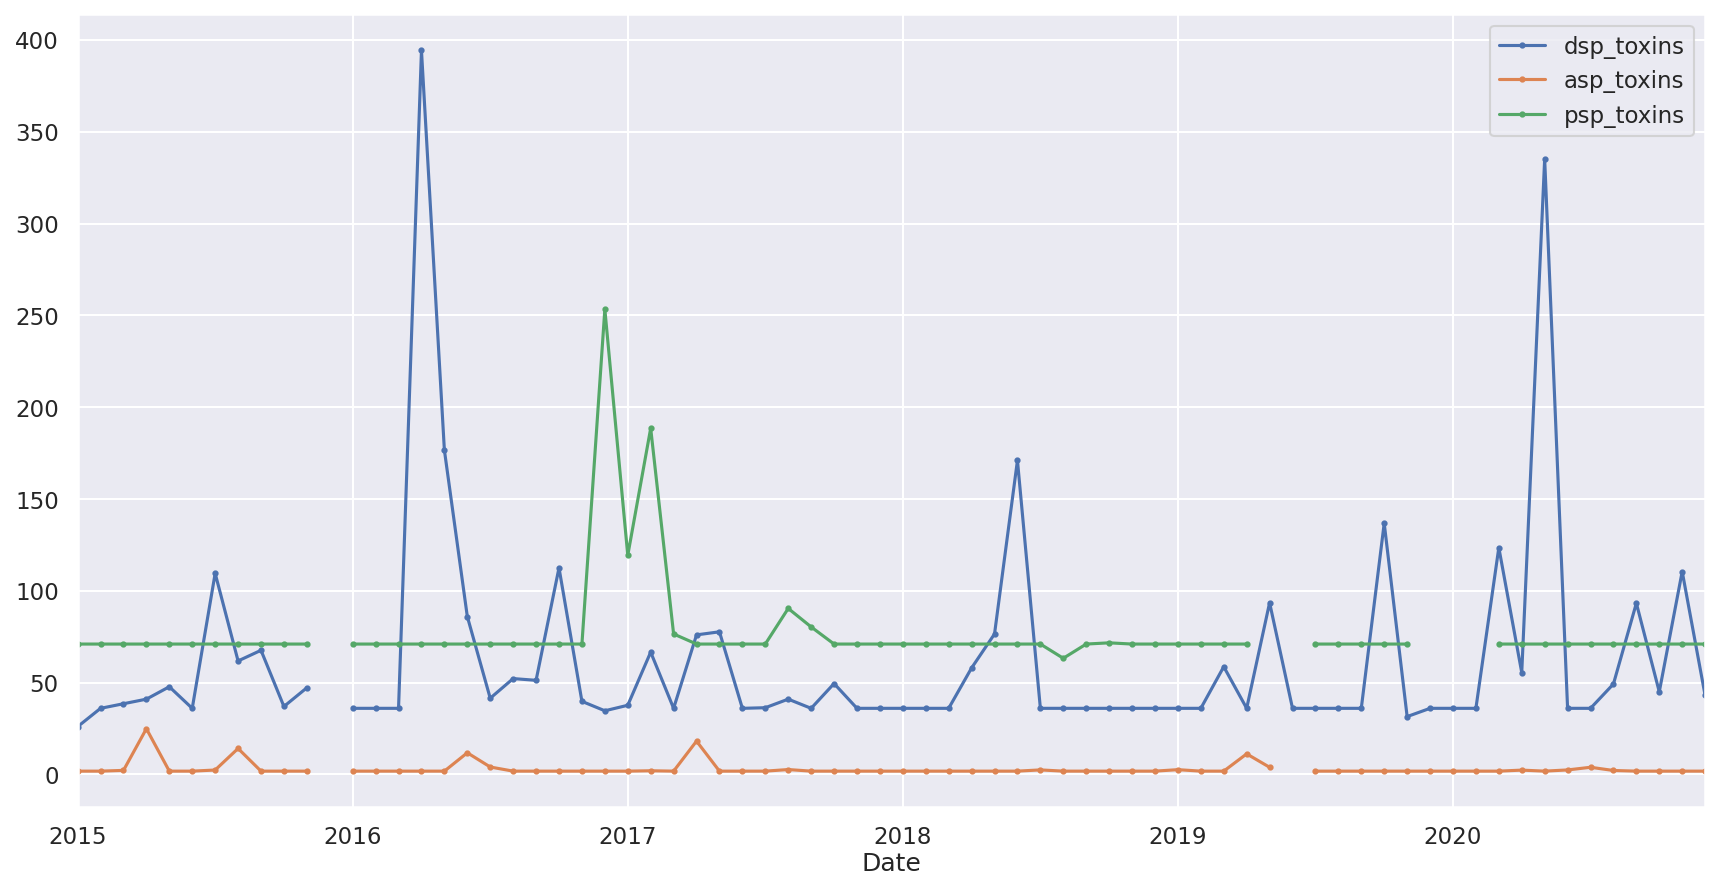

In [86]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Amêijoa-branca", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Amêijoa-branca", "dsp_toxins", "M")

## Compare species

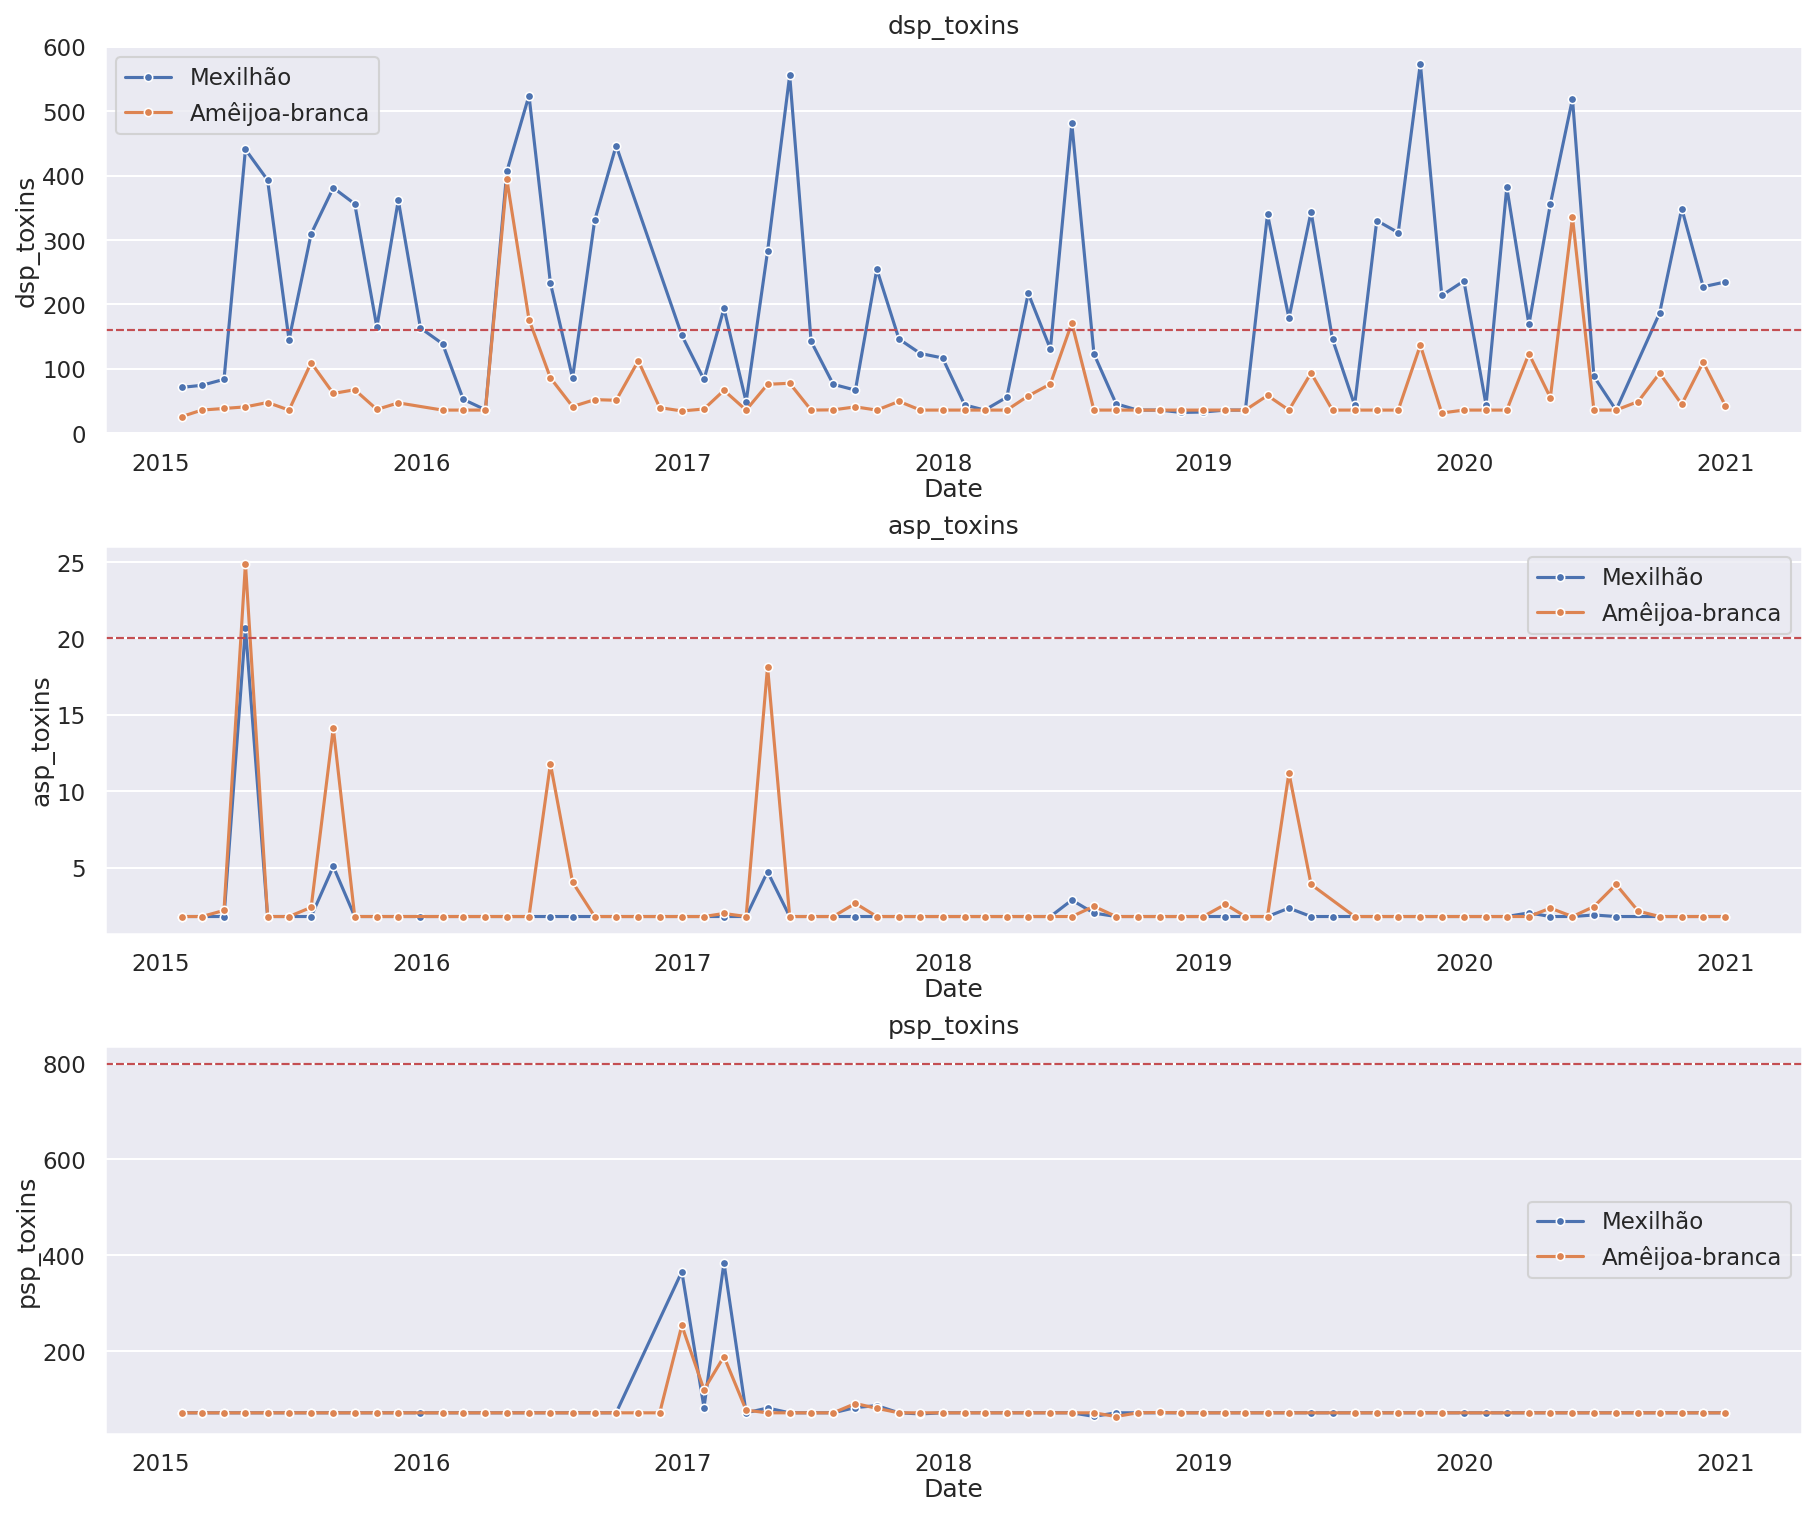

In [22]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

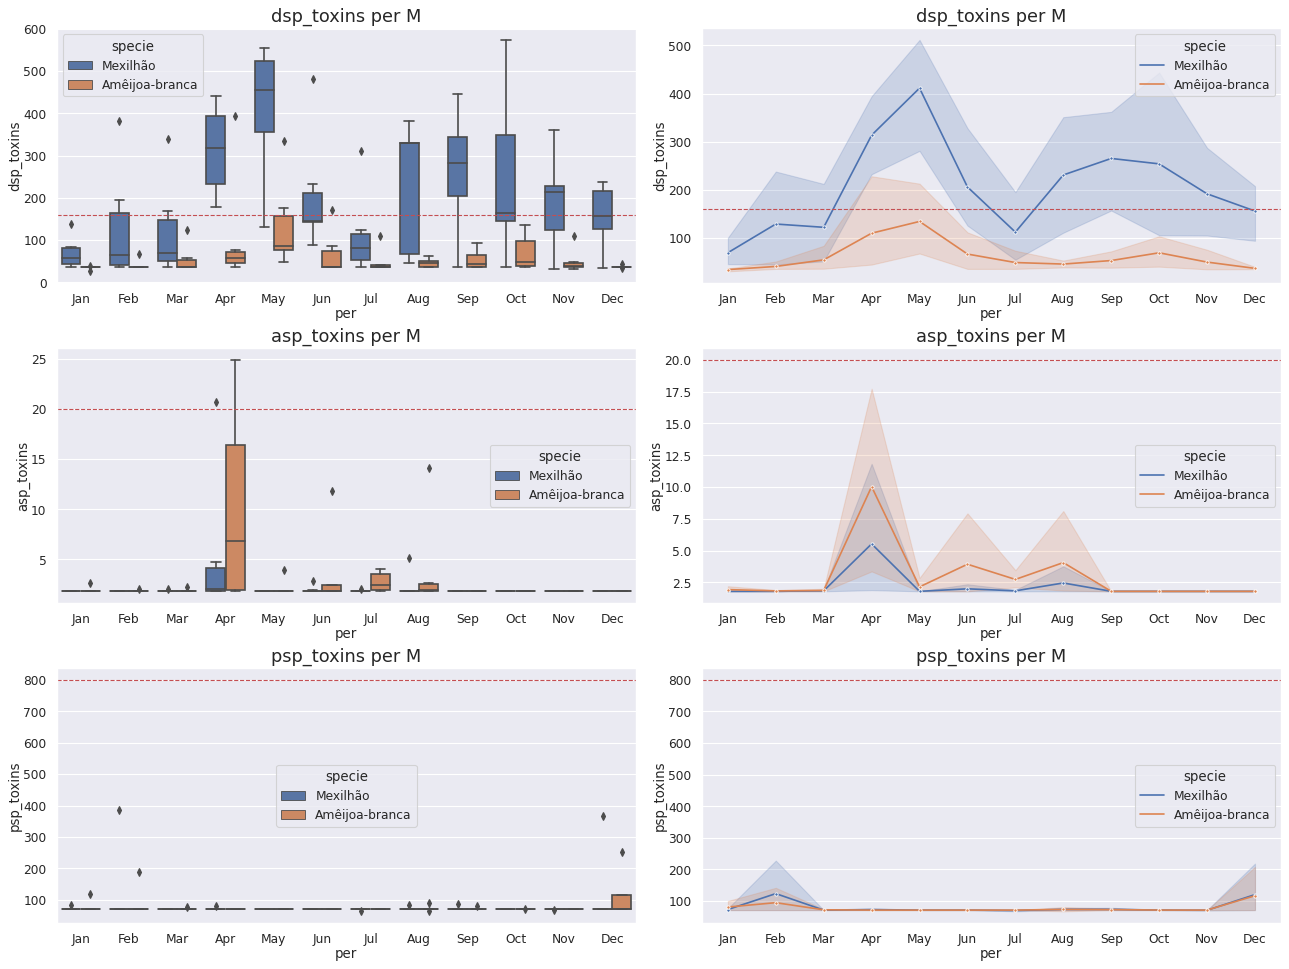

In [19]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

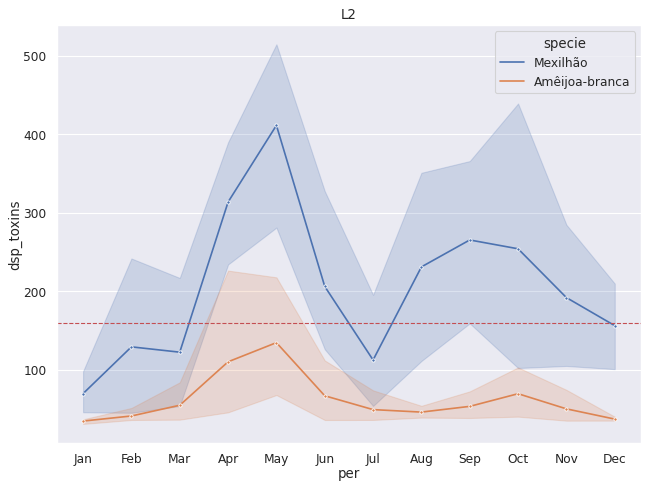

In [87]:
by="M"
fig, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True, dpi=80)

ax = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax, 160,"lineplot")
ax.set_title("L2")
plt.show()

## Trend

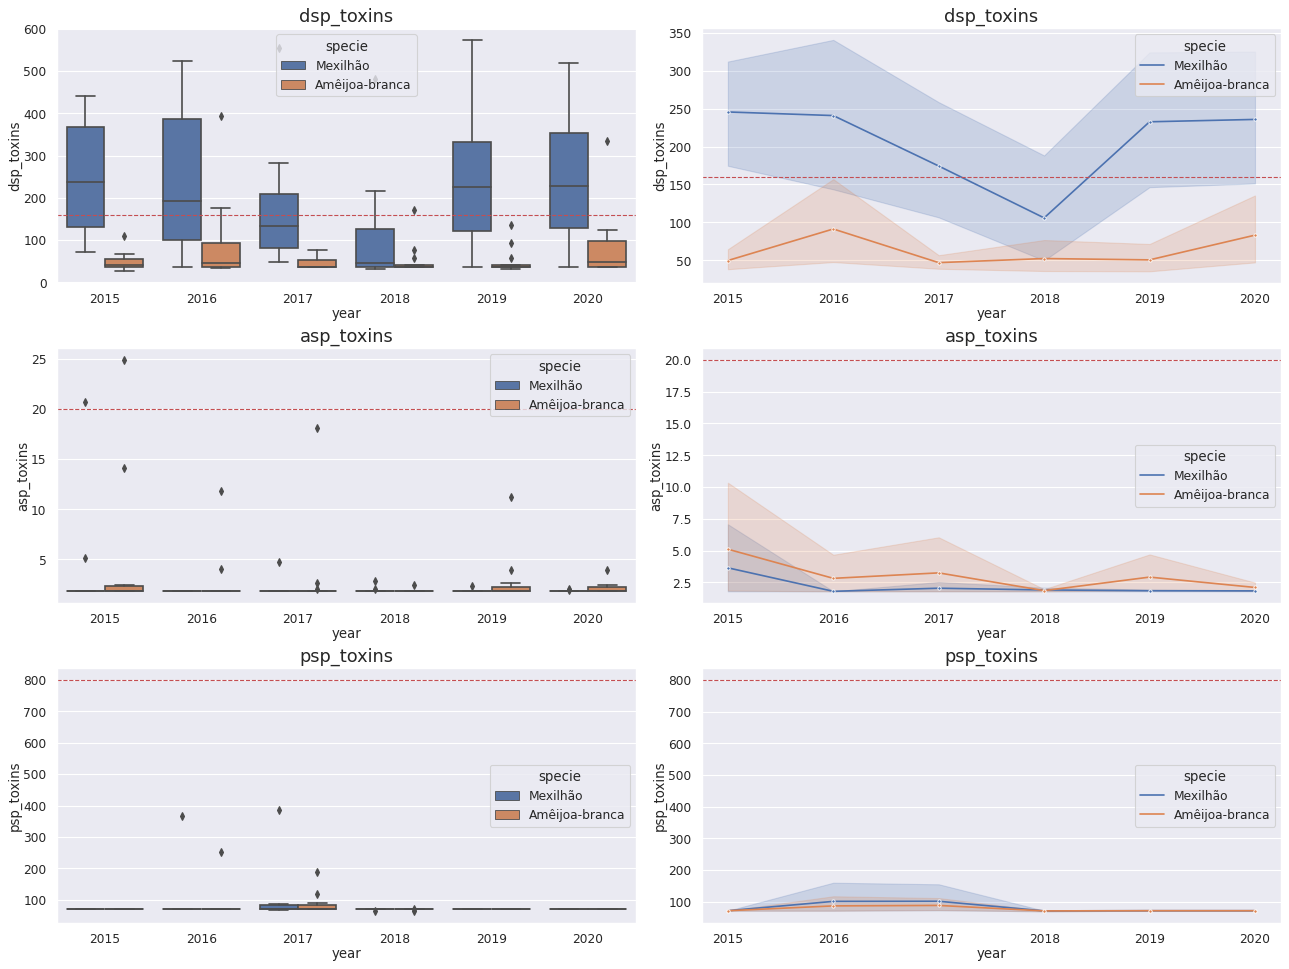

In [24]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

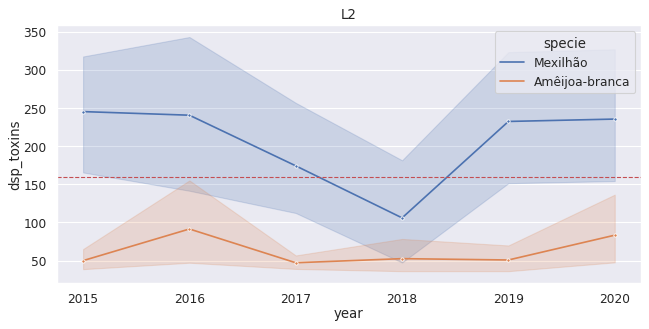

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,4), constrained_layout=True, dpi=80)

ax = compare_species_trend(biotoxins_ts, "L2", species, "dsp_toxins", ax, 160,"lineplot")
ax.set_title("L2")

plt.show()

# LOB

In [12]:
area = "LOB"
species = ["Mexilhão", "Berbigão"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão            292
Mexilhão            289
Amêijoa-japonesa     38
Amêijoa-boa          19
Amêijoa-macha        17
Longueirão           13
Amêijoa-branca        1
Name: Species, dtype: int64

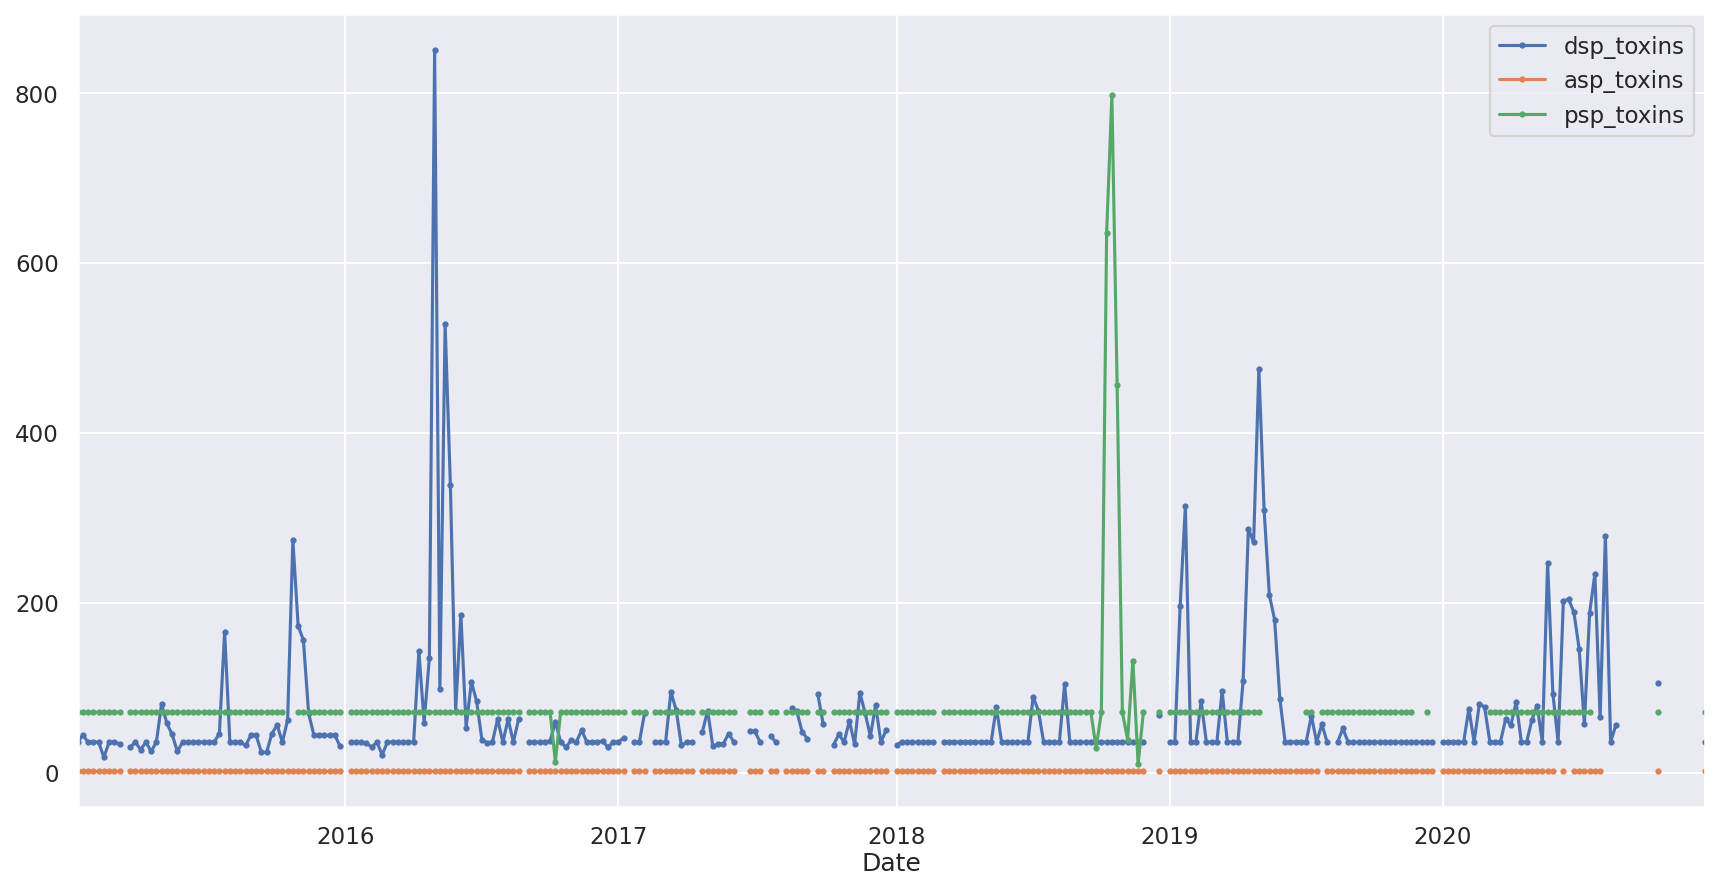

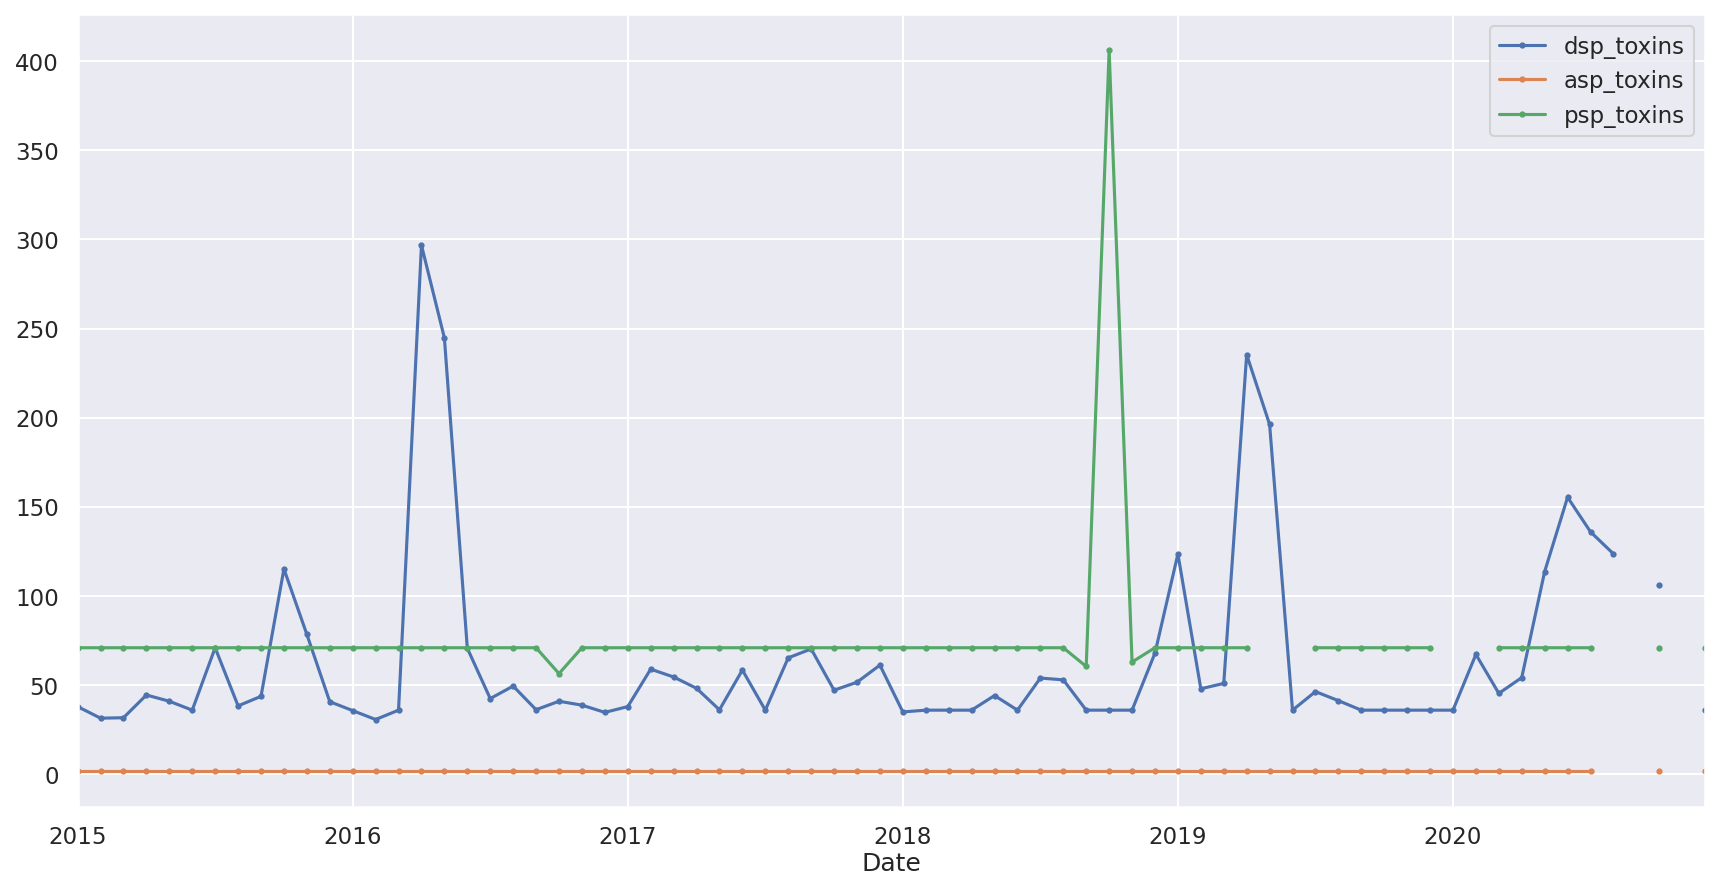

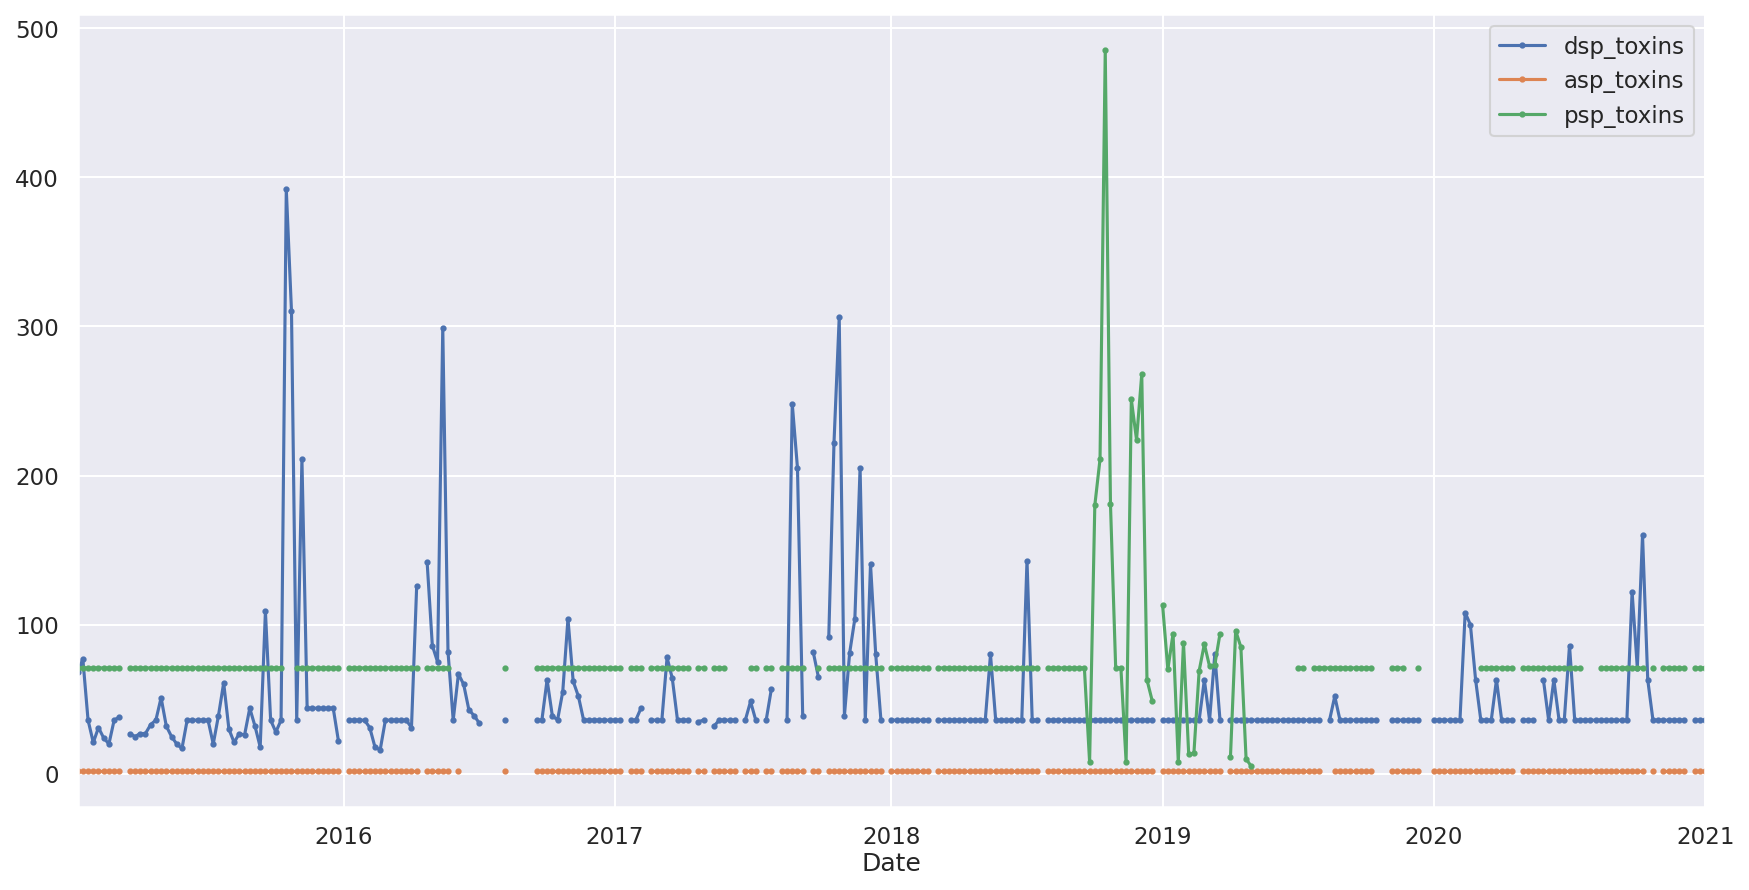

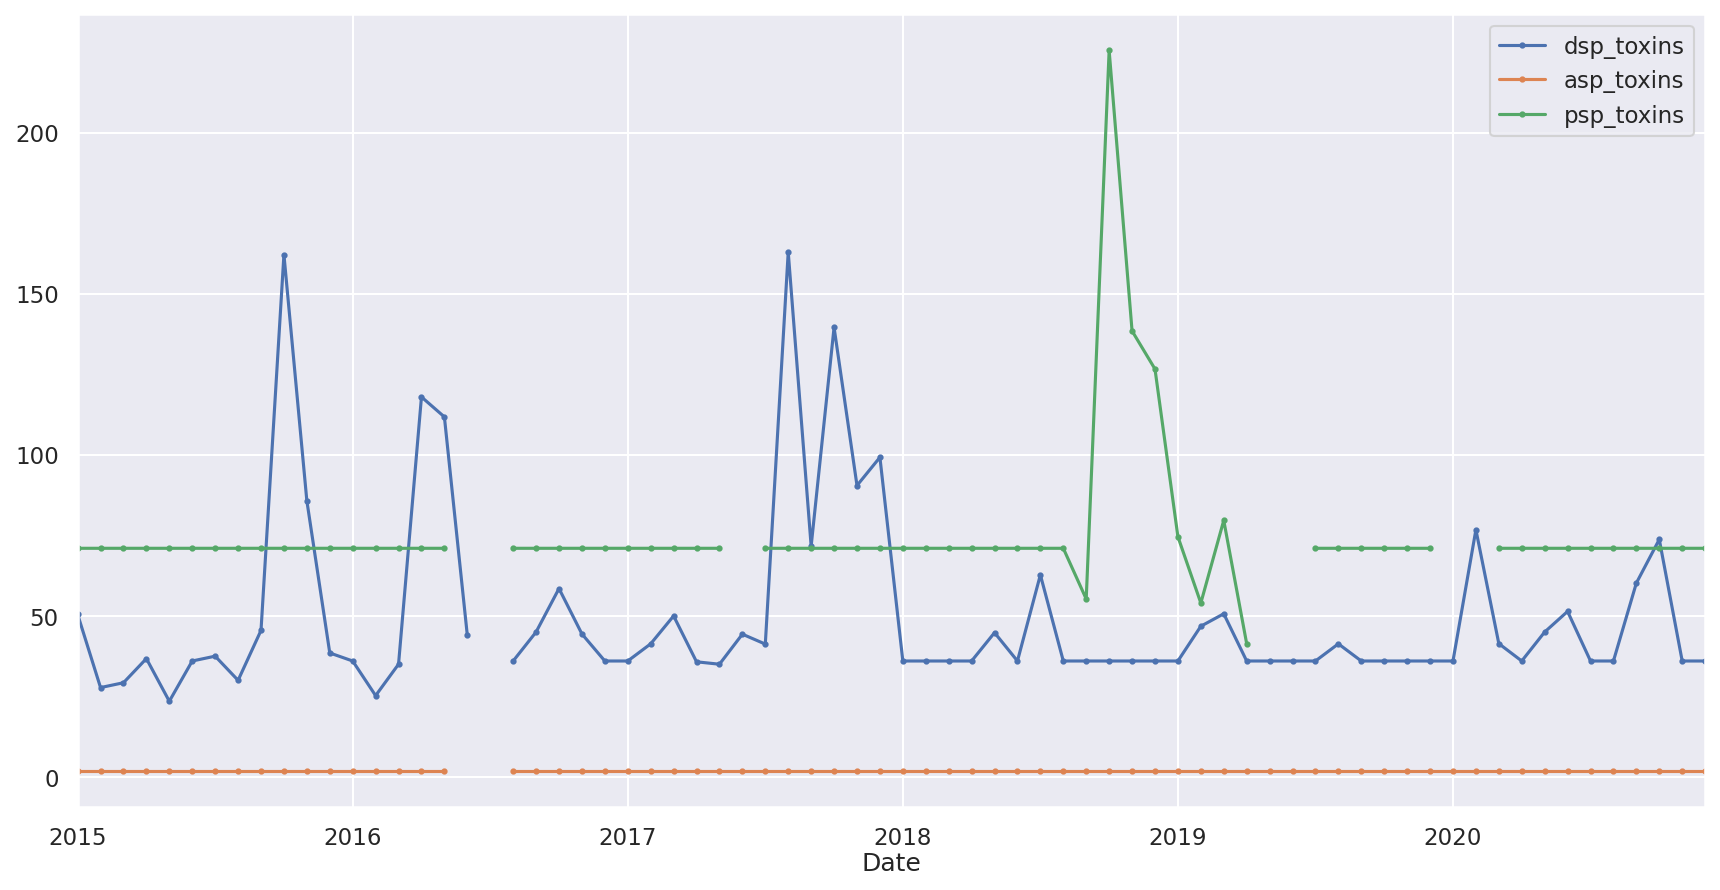

In [13]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "M")

## Compare species

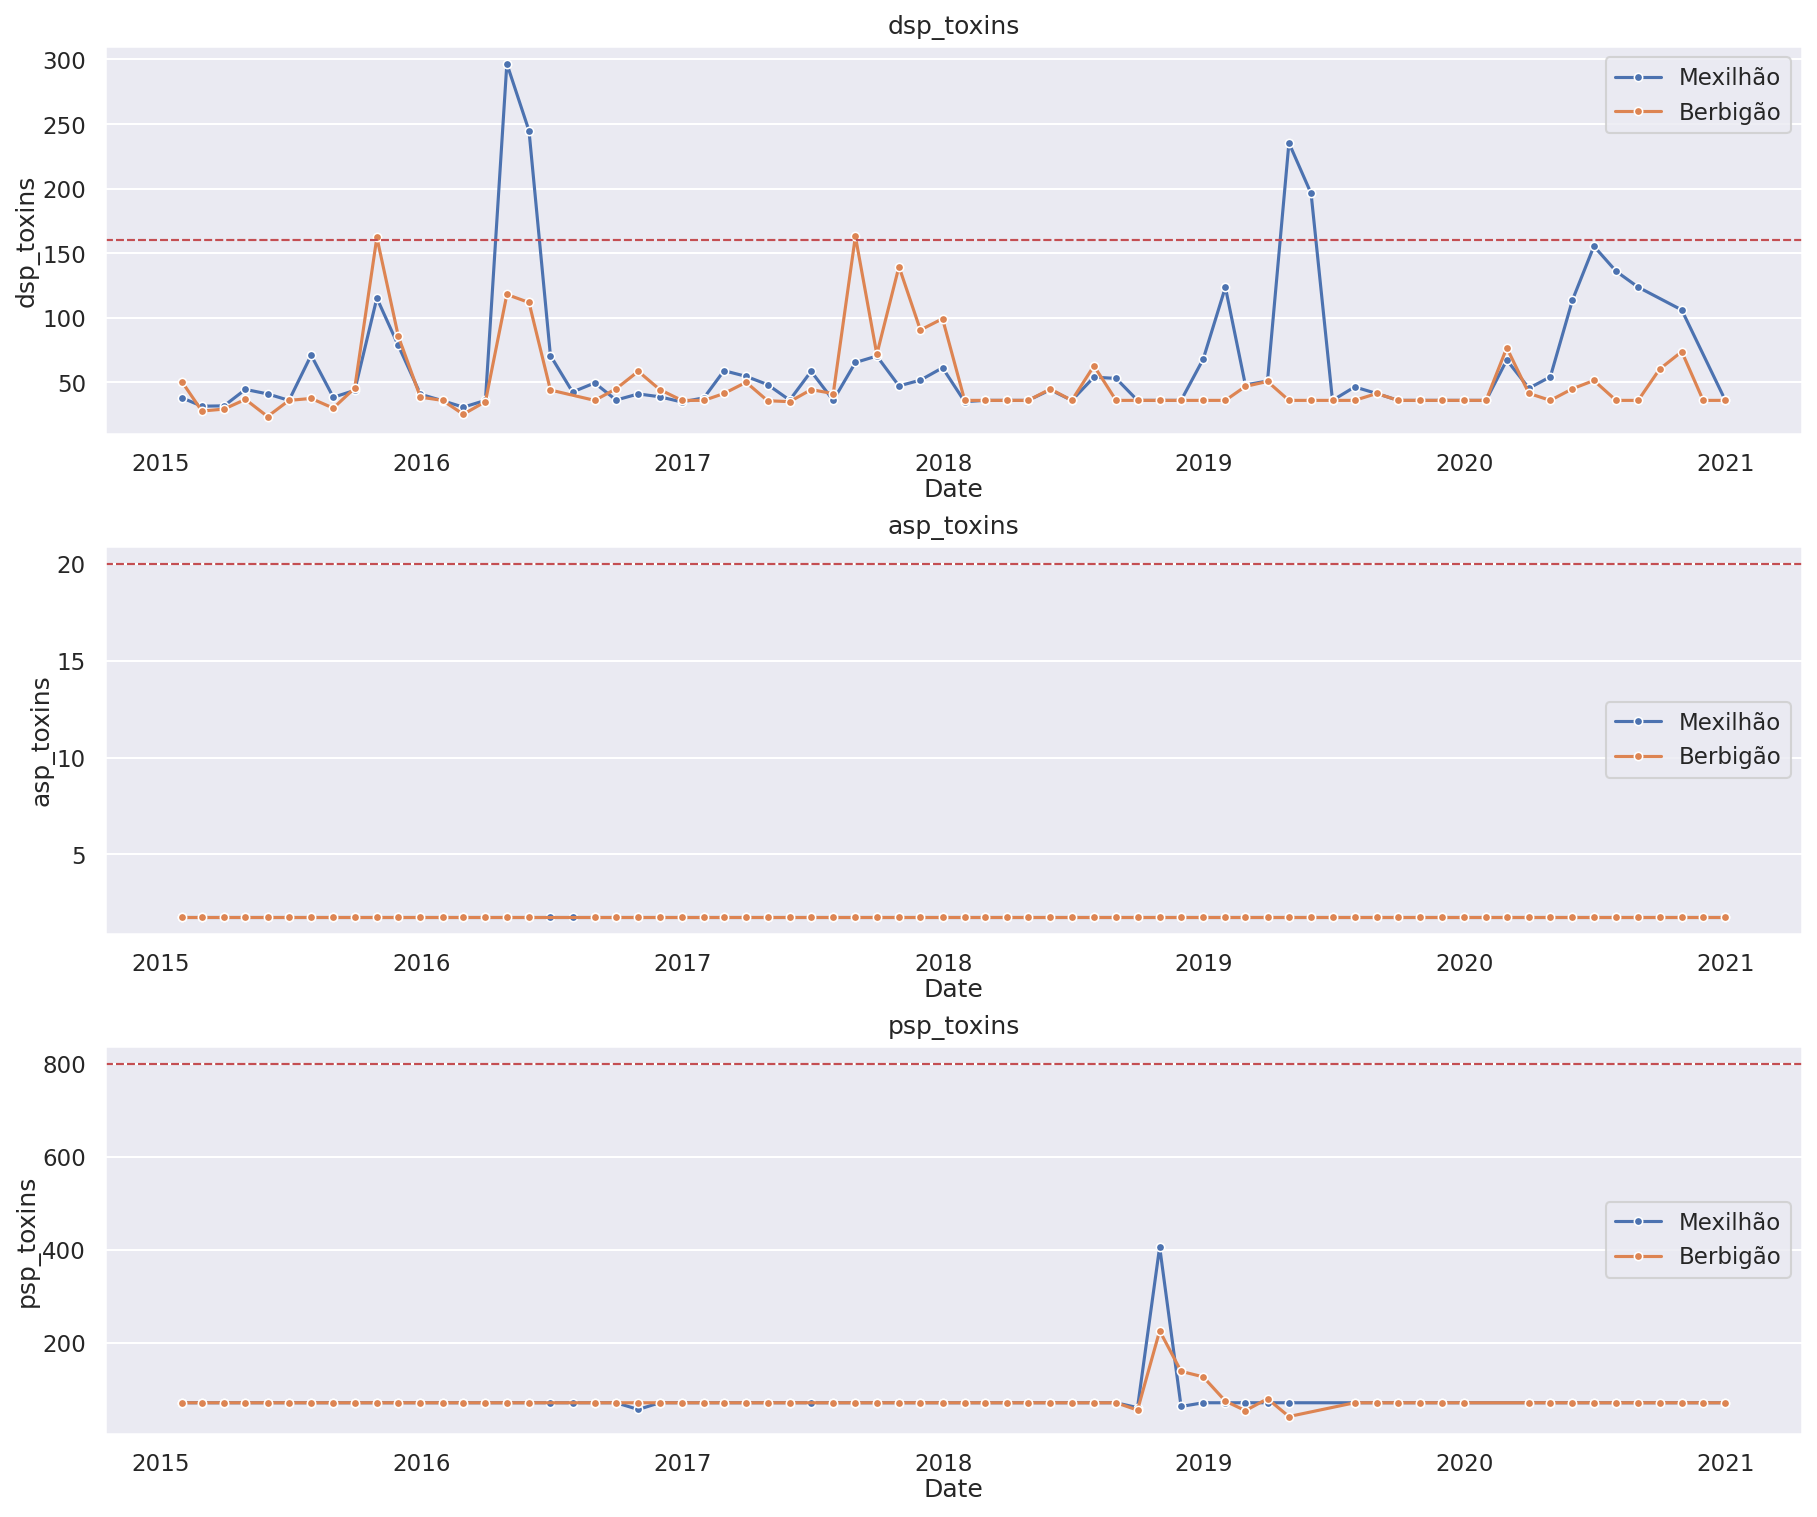

In [14]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

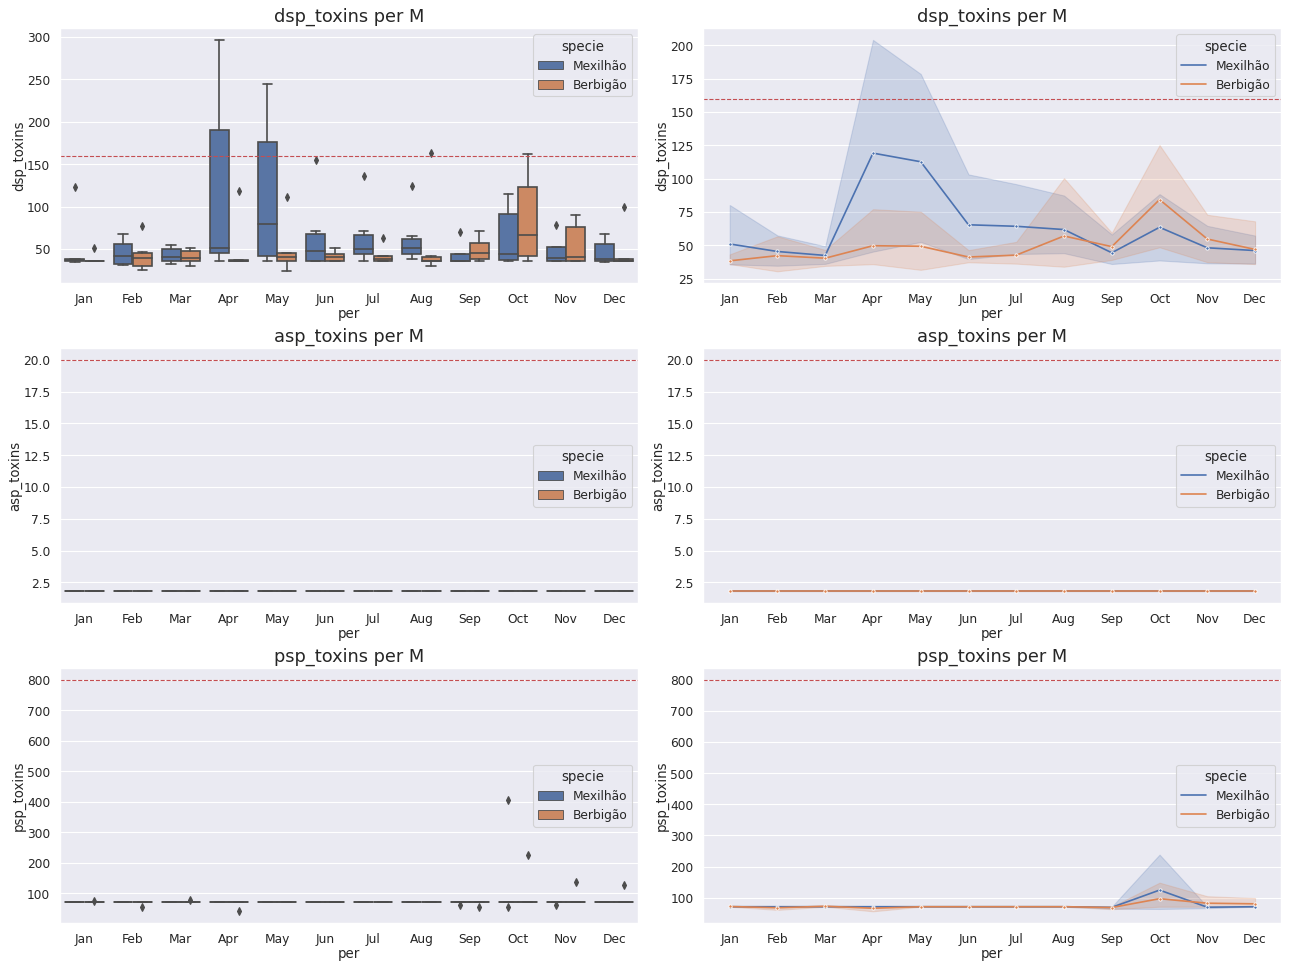

In [15]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

## Trend

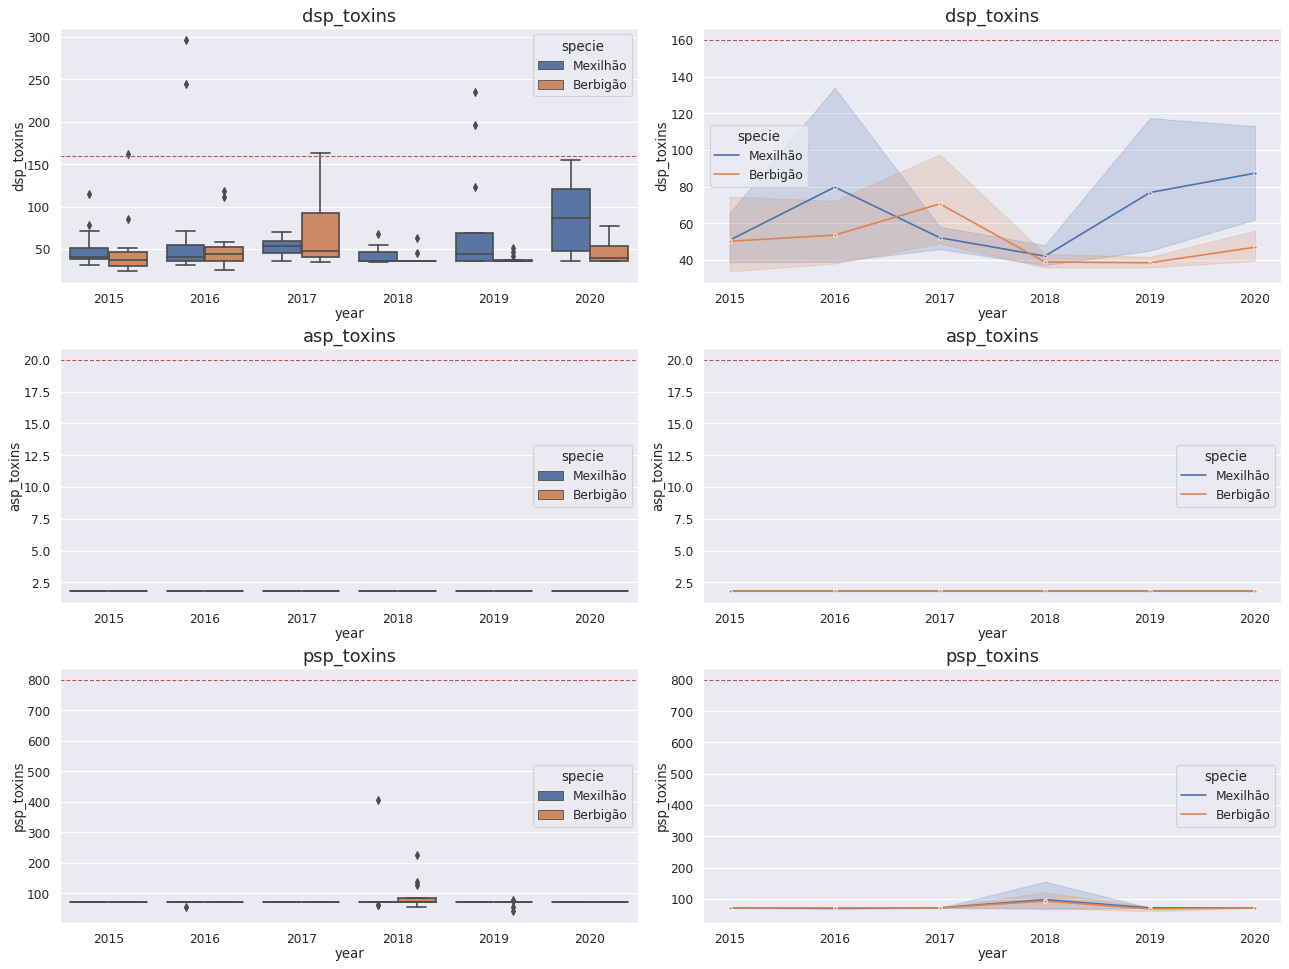

In [16]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

# OLH2 - L9 -> Conquilha

In [23]:
#onde há Conquilha?
print("Conquilha")
print(biotoxins[ biotoxins["Species"]=="Conquilha" ]["Production_Area"].value_counts())
print("\n##########\n")
print(biotoxins[ biotoxins["Species"]=="Mexilhão" ]["Production_Area"].value_counts().head(10))

Conquilha
L9      289
L8      261
L6      139
L5b      92
L5       28
L7c2     19
L7c      14
OLH4      1
L4        1
Name: Production_Area, dtype: int64

##########

LAL      300
RIAV1    293
L7c1     291
LOB      289
RIAV2    288
ETJ1     288
OLH2     284
L5b      282
OLH4     277
TAV      272
Name: Production_Area, dtype: int64


Par Conquilha-Mexilhão será L8 - OLH2, são adjacentes

In [24]:
areas = ["OLH2", "L9"]
area = '_'.join(areas)

species = ["Mexilhão", "Conquilha"]

#merge de L8 com OLH2
temp = biotoxins_ts.copy()
#drop mexilhao de um lado e conquilha do outro:
for i in range(len(areas)):
    temp = temp[ ~((temp["Production_Area"]==areas[i]) & (temp["Species"]==list(reversed(species))[i])) ]
    
temp.loc[ temp["Production_Area"].isin(areas), "Production_Area"] = area
#temp = temp[ temp["Species"].isin(species) ]
temp[ (temp["Production_Area"]==area)]["Species"].value_counts()

Conquilha                 289
Mexilhão                  284
Pé-de-burrinho             35
Amêijoa-branca             27
Amêijoa-boa                22
Berbigão                   21
Longueirão                 17
Amêijoa-cão                14
Ostra-japonesa/gigante     11
Ostra                       4
Amêijoa-macha               4
Pé-burrinho                 1
Name: Species, dtype: int64

In [25]:
ts_week_m = get_ts(temp, area, "Mexilhão", "dsp_toxins", "W", plot=False)
ts_month_m = get_ts(temp, area, "Mexilhão", "dsp_toxins", "M", plot=False)

ts_week_b = get_ts(temp, area, "Conquilha", "dsp_toxins", "W", plot=False)
ts_month_b = get_ts(temp, area, "Conquilha", "dsp_toxins", "M", plot=False)

## Compare species

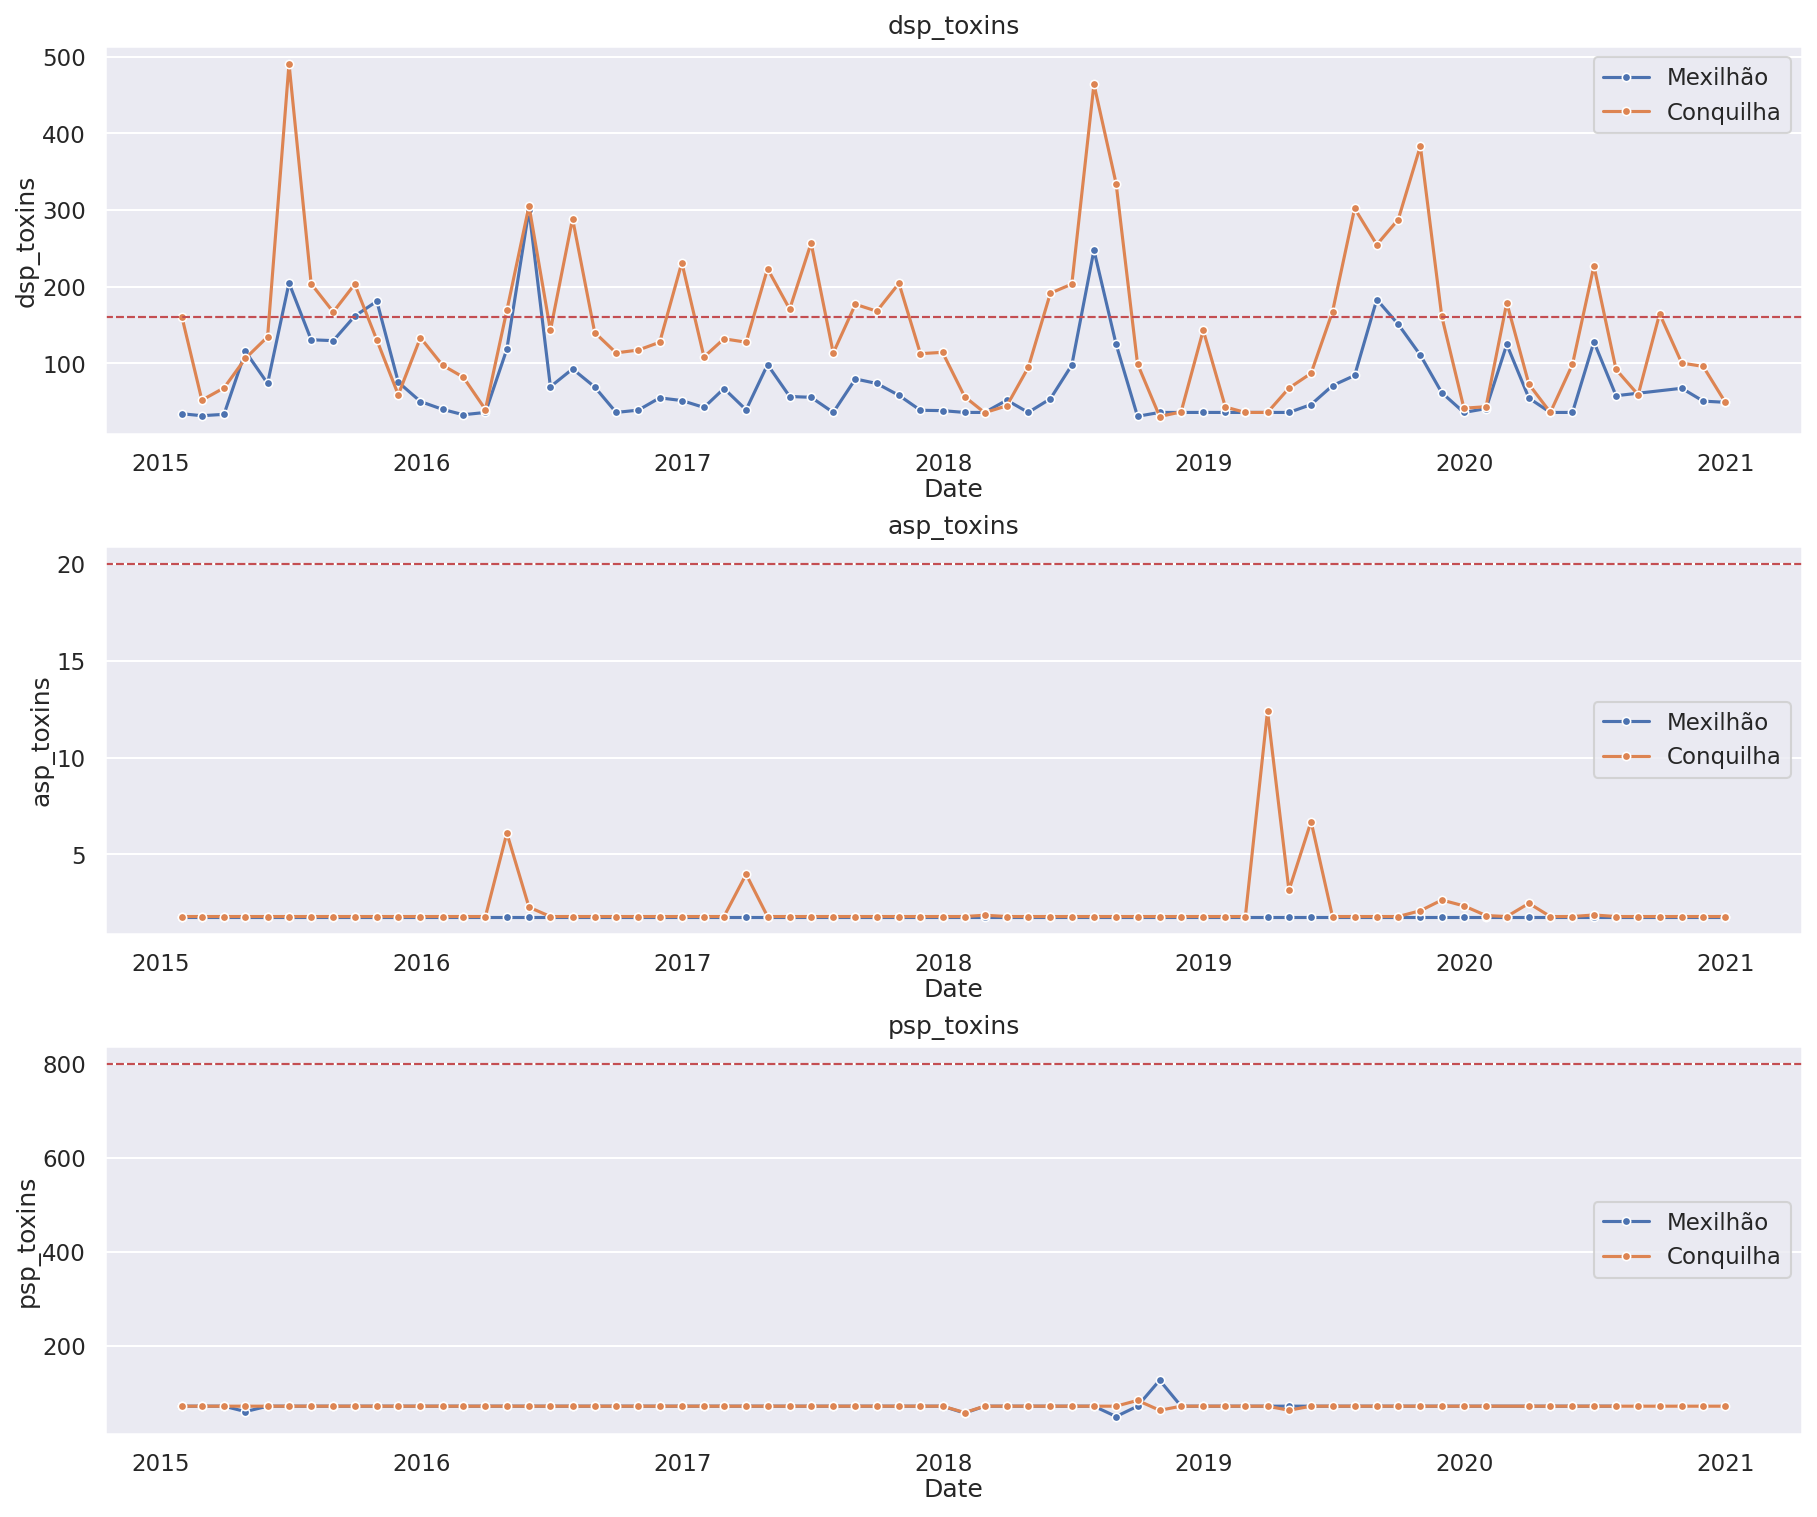

In [26]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(temp, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(temp, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(temp, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

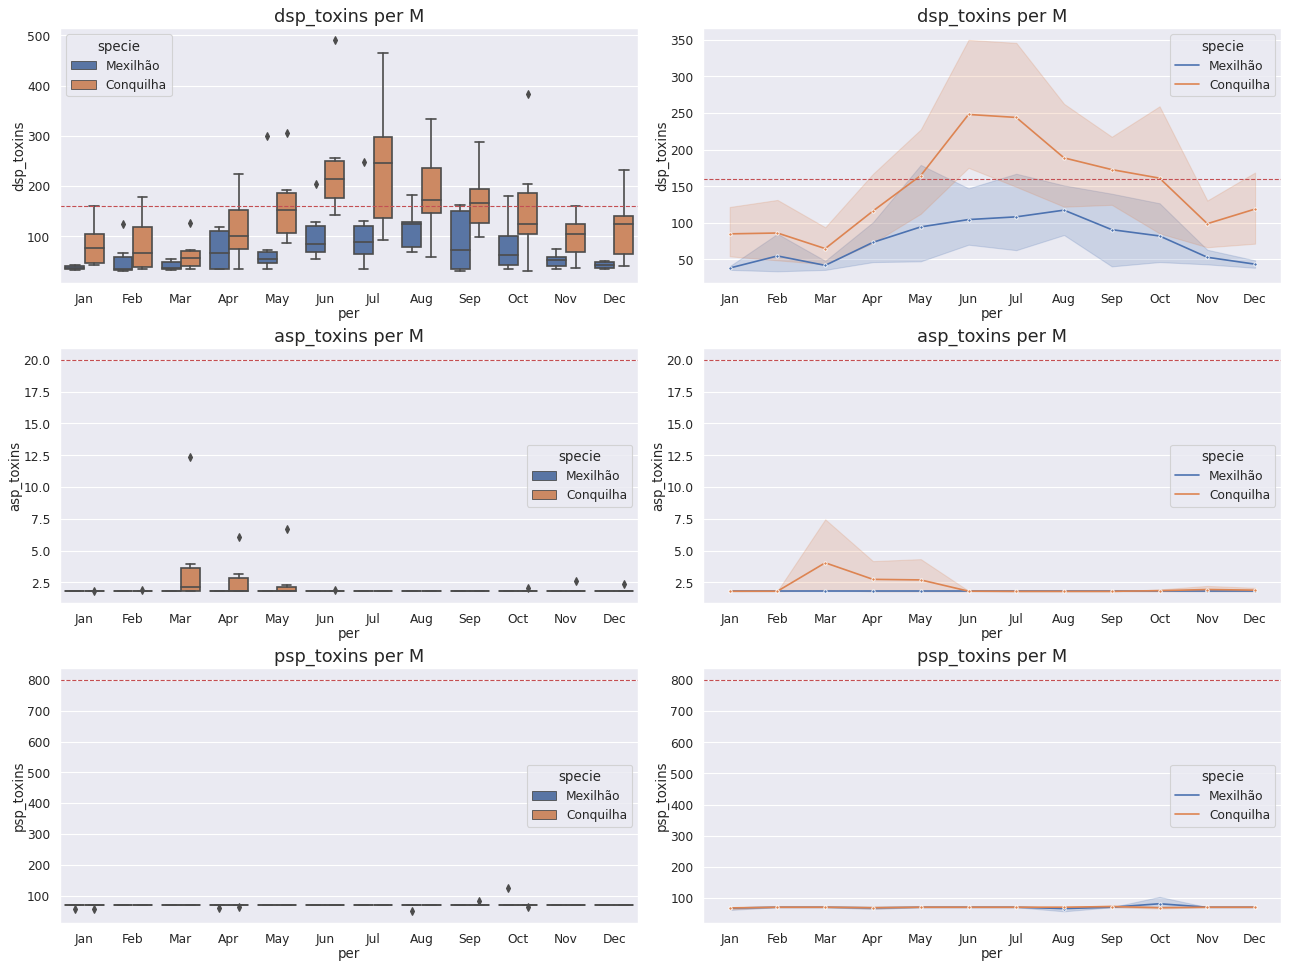

In [27]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(temp, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(temp, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(temp, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(temp, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(temp, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(temp, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

### DISPLAY

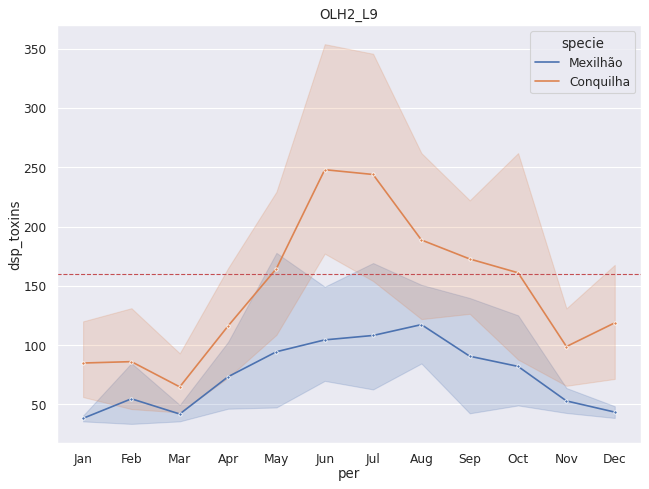

In [28]:
by="M"
#fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True, dpi=80)
fig, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True, dpi=80)

#ax[0] = compare_species_seasonality(biotoxins_ts, "RIAV1", species, "dsp_toxins", by, ax[0], 160,"lineplot")
#ax[1] = compare_species_seasonality(biotoxins_ts, "RIAV2", species, "dsp_toxins", by, ax[1], 160,"lineplot")
#ax[0].set_title("RIAV1")
#ax[1].set_title("RIAV2")

ax = compare_species_seasonality(temp, area, species, "dsp_toxins", by, ax, 160,"lineplot")
ax.set_title(area)

plt.show()

## Trend

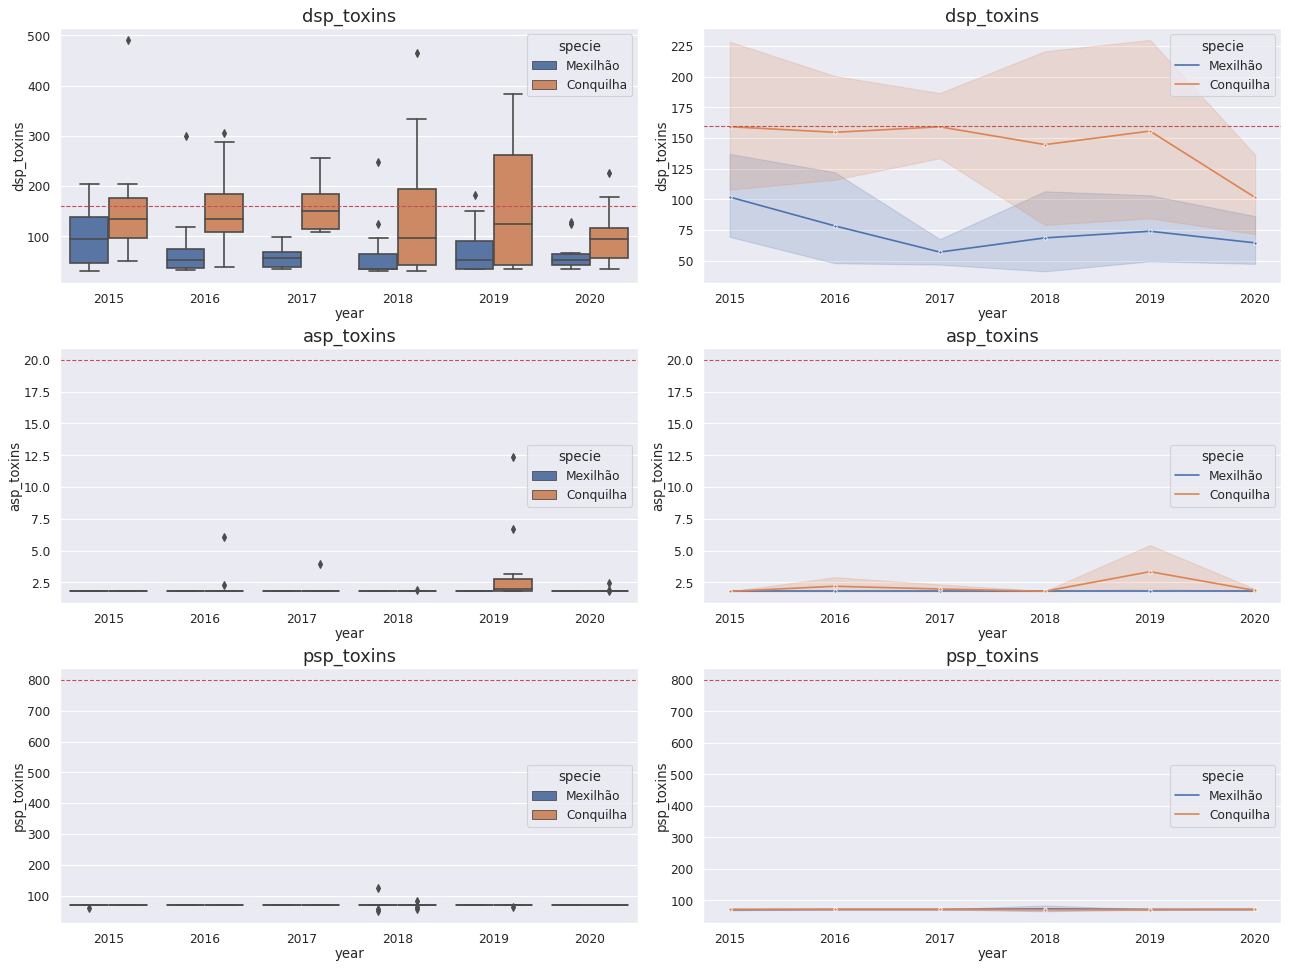

In [29]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(temp, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(temp, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(temp, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(temp, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(temp, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(temp, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

### DISPLAY

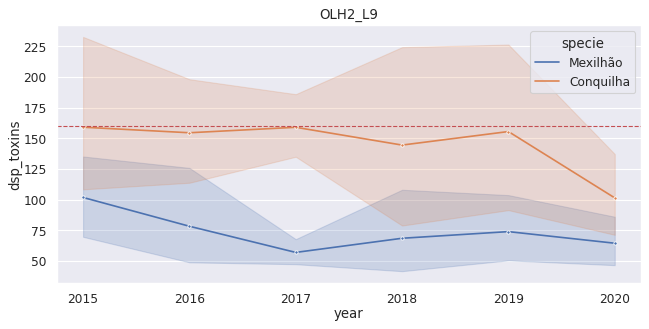

In [30]:
#fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True, dpi=80)
fig, ax = plt.subplots(1,1, figsize=(8,4), constrained_layout=True, dpi=80)

#ax[0] = compare_species_trend(biotoxins_ts, "RIAV1", species, "dsp_toxins", ax[0], 160,"lineplot")
#ax[1] = compare_species_trend(biotoxins_ts, "RIAV2", species, "dsp_toxins", ax[1], 160,"lineplot")

#ax[0].set_title("RIAV1")
#ax[1].set_title("RIAV2")

ax = compare_species_trend(temp, area, species, "dsp_toxins", ax, 160,"lineplot")
ax.set_title(area)


plt.show()

# DISPLAY geral

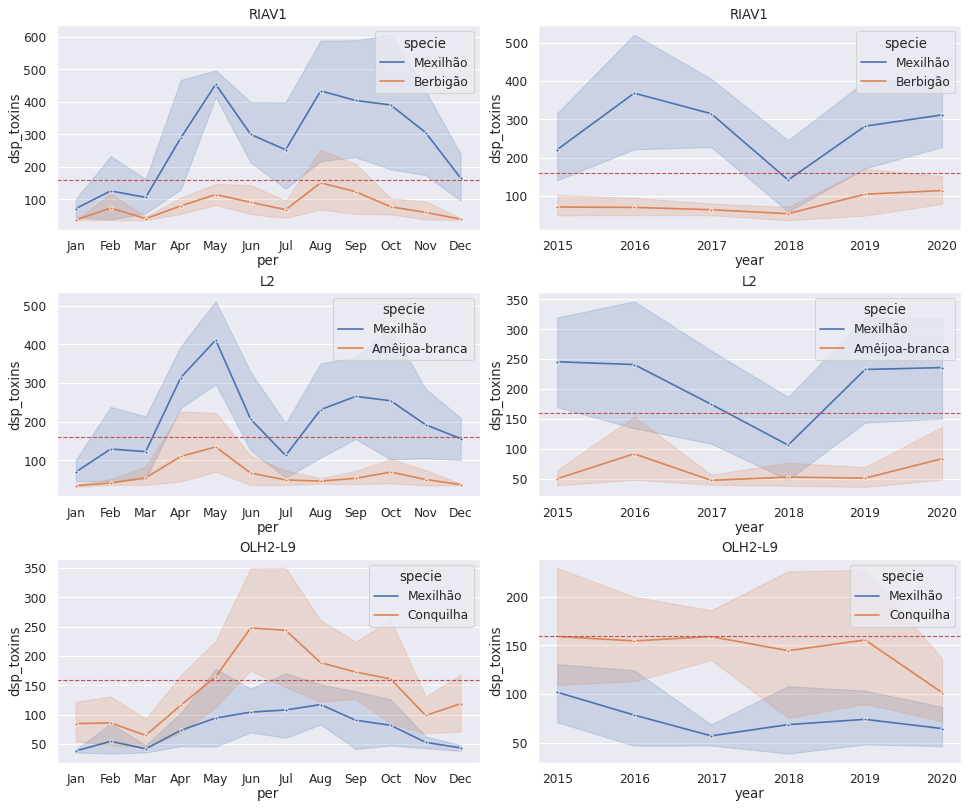

In [34]:
by="M"
#fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True, dpi=80)
fig, ax = plt.subplots(3,2, figsize=(12,10), constrained_layout=True, dpi=80)

#ax[0] = compare_species_seasonality(biotoxins_ts, "RIAV1", species, "dsp_toxins", by, ax[0], 160,"lineplot")
#ax[1] = compare_species_seasonality(biotoxins_ts, "RIAV2", species, "dsp_toxins", by, ax[1], 160,"lineplot")
#ax[0].set_title("RIAV1")
#ax[1].set_title("RIAV2")

ax[0][0] = compare_species_seasonality(biotoxins_ts, "RIAV1", ["Mexilhão", "Berbigão"], "dsp_toxins", by, ax[0][0], 160,"lineplot")
ax[0][0].set_title("RIAV1")
ax[0][1] = compare_species_trend(biotoxins_ts, "RIAV1", ["Mexilhão", "Berbigão"], "dsp_toxins", ax[0][1], 160,"lineplot")
ax[0][1].set_title("RIAV1")
ax[1][0] = compare_species_seasonality(biotoxins_ts, "L2", ["Mexilhão", "Amêijoa-branca"], "dsp_toxins", by, ax[1][0], 160,"lineplot")
ax[1][0].set_title("L2")
ax[1][1] = compare_species_trend(biotoxins_ts, "L2", ["Mexilhão", "Amêijoa-branca"], "dsp_toxins", ax[1][1], 160,"lineplot")
ax[1][1].set_title("L2")
ax[2][0] = compare_species_seasonality(temp, area, ["Mexilhão", "Conquilha"], "dsp_toxins", by, ax[2][0], 160,"lineplot")
ax[2][0].set_title("OLH2-L9")
ax[2][1] = compare_species_trend(temp, area, ["Mexilhão", "Conquilha"], "dsp_toxins", ax[2][1], 160,"lineplot")
ax[2][1].set_title("OLH2-L9")

plt.show()